In [1]:
# Data Manipulation and Handling
import polars as pl
import pandas as pd
import numpy as np
import psycopg2

# DB Credentials
from dotenv import load_dotenv
import os
import sys
from sqlalchemy import create_engine

# Machine Learning Libraries
import torch
import xgboost as xgb
import lightgbm as lgb
# from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, roc_curve

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Handling Imbalanced Data
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as ImbPipeline

# Gradient Boosting Libraries
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

# Model Lifecycle Management
import mlflow
import mlflow.sklearn

# Distributed Computing
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import RandomForestClassifier as SparkRFClassifier

# Model Interpretability
import shap

# Hyperparameter Optimization
import optuna

# Automated Feature Engineering
import featuretools as ft

# Add parent directory to sys.path
current_dir = os.getcwd()
parent_dir = os.path.abspath(os.path.join(current_dir, os.pardir))
if parent_dir not in sys.path:
    sys.path.insert(0, parent_dir)

# Custom Modules
from fetch_data_hook import fetch_sql_code, fetch_sql_file

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
'PYARROW_IGNORE_TIMEZONE' environment variable was not set. It is required to set this environment variable to '1' in both driver and executor sides if you use pyarrow>=2.0.0. pandas-on-Spark will set it for you but it does not work if there is a Spark context already launched.


# ML Pipeline Flow

In [2]:
# 1. EDA Analysis
# 2. Feature Engineering
# 3. Train-Test Split
# 4. Feature Scaling: {normalization/standardization, dimension reduction techniques, handling imbalance datasets/sampling}
# 5. Model Training -> Tuning -> Evaluating
# 6. Model Prediction
# 7. Model Deployment

In [3]:
churn_df = fetch_sql_code('''
WITH temp1 AS (
    SELECT
        *,
        ROW_NUMBER() OVER (PARTITION BY user_id ORDER BY timestamp) AS rn,
        timestamp::date - ROW_NUMBER() OVER (PARTITION BY user_id ORDER BY timestamp)::int AS streak_id
    FROM
        equity_value_data
),
temp2 AS (
    SELECT
        user_id,
        MIN(timestamp::date) AS start_streak_date,
        MAX(timestamp::date) AS end_streak_date,
        COUNT(*) AS duration_of_above10_streak
    FROM
        temp1
    GROUP BY
        user_id, streak_id
),
temp3 AS (
    SELECT
        *,
        LAG(end_streak_date) OVER (PARTITION BY user_id ORDER BY start_streak_date ASC) AS prev_above10_streak_date,
        start_streak_date - LAG(end_streak_date) OVER (PARTITION BY user_id ORDER BY start_streak_date ASC) AS duration_between_above10_streaks
    FROM
        temp2
)
SELECT distinct user_id
FROM temp3
WHERE duration_between_above10_streaks >= 28
''')
churn_df
churn_users = set(churn_df['user_id'].tolist())

df = fetch_sql_code('''
select * from features_data
''')

df['churn_flag'] = df['user_id'].apply(lambda x: 1 if x in churn_users else 0 )
df


,risk_tolerance,investment_experience,liquidity_needs,platform,time_spent,instrument_type_first_traded,first_deposit_amount,time_horizon,user_id,churn_flag
0,high_risk_tolerance,limited_investment_exp,very_important_liq_need,Android,33.129417,stock,40.0,med_time_horizon,895044c23edc821881e87da749c01034,0
1,med_risk_tolerance,limited_investment_exp,very_important_liq_need,Android,16.573517,stock,200.0,short_time_horizon,458b1d95441ced242949deefe8e4b638,0
2,med_risk_tolerance,limited_investment_exp,very_important_liq_need,iOS,10.008367,stock,25.0,long_time_horizon,c7936f653d293479e034865db9bb932f,0
3,med_risk_tolerance,limited_investment_exp,very_important_liq_need,Android,1.031633,stock,100.0,short_time_horizon,b255d4bd6c9ba194d3a350b3e76c6393,0
4,high_risk_tolerance,limited_investment_exp,very_important_liq_need,Android,8.187250,stock,20.0,long_time_horizon,4a168225e89375b8de605cbc0977ae91,0
...,...,...,...,...,...,...,...,...,...,...
5579,high_risk_tolerance,limited_investment_exp,very_important_liq_need,Android,8.339283,stock,300.0,long_time_horizon,03880c726d8a4e5db006afe4119ad974,0
5580,med_risk_tolerance,limited_investment_exp,somewhat_important_liq_need,iOS,7.241383,stock,100.0,short_time_horizon,ae8315109657f44852b24c6bca4decd6,1
5581,med_risk_tolerance,no_investment_exp,very_important_liq_need,both,22.967167,stock,50.0,short_time_horizon,f29c174989f9737058fe808fcf264135,0
5582,med_risk_tolerance,limited_investment_exp,somewhat_important_liq_need,iOS,10.338417,stock,100.0,long_time_horizon,24843497d1de88b2e7233f694436cb3a,0


In [4]:
'''
1. Data Preprocessing: This step will involve reading the dataset, handling categorical and numerical columns, scaling the data, and feature engineering.
2. Handling Imbalance: Using SMOTE to oversample the minority class (churners).
3. Automated Hyperparameter Tuning: We'll use Optuna to automatically select the best model (among XGBoost, LightGBM, RandomForest, and Logistic Regression) based on the AUC score.
4. Final Model Training and Evaluation: After Optuna selects the best model, it will be retrained on the full resampled dataset, and we will evaluate the model's performance.
5. Feature Importance Analysis with SHAP: Finally, we'll interpret the model using SHAP to gain insights into which features are most influential.'''

"\n1. Data Preprocessing: This step will involve reading the dataset, handling categorical and numerical columns, scaling the data, and feature engineering.\n2. Handling Imbalance: Using SMOTE to oversample the minority class (churners).\n3. Automated Hyperparameter Tuning: We'll use Optuna to automatically select the best model (among XGBoost, LightGBM, RandomForest, and Logistic Regression) based on the AUC score.\n4. Final Model Training and Evaluation: After Optuna selects the best model, it will be retrained on the full resampled dataset, and we will evaluate the model's performance.\n5. Feature Importance Analysis with SHAP: Finally, we'll interpret the model using SHAP to gain insights into which features are most influential."

### Step 1: Data Preprocessing and Feature Engineering

In [5]:
'''Data Preprocessing: Label encoding, scaling, and feature engineering.
Handling Imbalanced Data: SMOTE was used to oversample the minority class.
Modeling and Hyperparameter Tuning: Models like XGBoost, LightGBM, RandomForest, and Logistic Regression were optimized using Optuna.
Evaluation: The best model was chosen based on the highest AUC score.
Explainability: SHAP was used to interpret the best model’s predictions.'''

'Data Preprocessing: Label encoding, scaling, and feature engineering.\nHandling Imbalanced Data: SMOTE was used to oversample the minority class.\nModeling and Hyperparameter Tuning: Models like XGBoost, LightGBM, RandomForest, and Logistic Regression were optimized using Optuna.\nEvaluation: The best model was chosen based on the highest AUC score.\nExplainability: SHAP was used to interpret the best model’s predictions.'

In [6]:
# Label encoding for categorical variables
label_enc = LabelEncoder()
df['risk_tolerance'] = label_enc.fit_transform(df['risk_tolerance'])
df['investment_experience'] = label_enc.fit_transform(df['investment_experience'])
df['liquidity_needs'] = label_enc.fit_transform(df['liquidity_needs'])
df['platform'] = label_enc.fit_transform(df['platform'])
df['time_horizon'] = label_enc.fit_transform(df['time_horizon'])

# Scaling the numerical features
scaler = StandardScaler()
df[['time_spent', 'first_deposit_amount']] = scaler.fit_transform(df[['time_spent', 'first_deposit_amount']])

# Feature Engineering: Additional features
df['deposit_per_time'] = df['first_deposit_amount'] / (df['time_spent'] + 1)  # Avoid division by zero
df['is_high_risk'] = (df['risk_tolerance'] == 0).astype(int)  # Assuming 0 = high risk


# Split the dataset into features and target
X = df.drop(columns=['user_id', 'churn_flag'])

# One-hot encode categorical variables
X = pd.get_dummies(X, drop_first=True)

y = df['churn_flag']

# Handle imbalance using SMOTE
smote = SMOTE(random_state=42)
X_original = X  # Store the original feature matrix
y_original = y  # Store the original target variable
X_resampled, y_resampled = smote.fit_resample(X_original, y_original)


In [7]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state=42)


In [8]:
import optuna

# Define the objective function for hyperparameter tuning
def objective(trial):
    # Suggest model type
    model_type = trial.suggest_categorical('model_type', ['xgboost', 'lightgbm', 'randomforest', 'logistic'])

    if model_type == 'xgboost':
        model = xgb.XGBClassifier(
            max_depth=trial.suggest_int('max_depth', 3, 10),
            learning_rate=trial.suggest_loguniform('learning_rate', 0.01, 0.3),
            n_estimators=trial.suggest_int('n_estimators', 50, 300),
            subsample=trial.suggest_uniform('subsample', 0.6, 1.0)
        )

    elif model_type == 'lightgbm':
        model = lgb.LGBMClassifier(
            num_leaves=trial.suggest_int('num_leaves', 20, 150),
            learning_rate=trial.suggest_loguniform('learning_rate', 0.01, 0.3),
            n_estimators=trial.suggest_int('n_estimators', 50, 300),
            feature_fraction=trial.suggest_uniform('feature_fraction', 0.6, 1.0)
        )

    elif model_type == 'randomforest':
        model = RandomForestClassifier(
            max_depth=trial.suggest_int('max_depth', 3, 10),
            n_estimators=trial.suggest_int('n_estimators', 50, 300),
            max_features=trial.suggest_categorical('max_features', ['sqrt', 'log2', None])
        )

    elif model_type == 'logistic':
        model = LogisticRegression(
            penalty=trial.suggest_categorical('penalty', ['l1', 'l2']),
            C=trial.suggest_float('C', 0.01, 10, log=True),
            solver='liblinear'
        )

    # Train the model
    model.fit(X_train, y_train)

    # Make predictions on the test set
    y_pred = model.predict(X_test)

    # Compute AUC score
    auc = roc_auc_score(y_test, y_pred)

    return auc


In [9]:
# Create an Optuna study and optimize
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

# Print the best trial and its parameters
print(f"Best trial: {study.best_trial}")
print(f"Best parameters: {study.best_params}")


[I 2024-10-03 19:41:57,707] A new study created in memory with name: no-name-c38e26de-4475-4ab5-8e98-4332b43a6580
C:\Users\cheng\AppData\Local\Temp\ipykernel_19784\2020316554.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate=trial.suggest_loguniform('learning_rate', 0.01, 0.3),
C:\Users\cheng\AppData\Local\Temp\ipykernel_19784\2020316554.py:13: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample=trial.suggest_uniform('subsample', 0.6, 1.0)
[I 2024-10-03 19:41:58,521] Trial 0 finished with value: 0.8985162377337237 and parameters: {'model_type': 'xgboost', 'max_depth': 7, 'learning_rate': 0.081336624536688, 'n_estimators': 293, 'subsample': 0.7079838683836442}. Best i

[LightGBM] [Warning] feature_fraction is set=0.9940930552591927, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9940930552591927
[LightGBM] [Warning] feature_fraction is set=0.9940930552591927, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9940930552591927
[LightGBM] [Info] Number of positive: 3744, number of negative: 3683
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000553 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 797
[LightGBM] [Info] Number of data points in the train set: 7427, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504107 -> initscore=0.016427
[LightGBM] [Info] Start training from score 0.016427


[I 2024-10-03 19:41:59,287] Trial 3 finished with value: 0.8865635547733717 and parameters: {'model_type': 'lightgbm', 'num_leaves': 45, 'learning_rate': 0.01069524849353468, 'n_estimators': 265, 'feature_fraction': 0.9940930552591927}. Best is trial 0 with value: 0.8985162377337237.


[LightGBM] [Warning] feature_fraction is set=0.9940930552591927, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9940930552591927


C:\Users\cheng\AppData\Local\Temp\ipykernel_19784\2020316554.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate=trial.suggest_loguniform('learning_rate', 0.01, 0.3),
C:\Users\cheng\AppData\Local\Temp\ipykernel_19784\2020316554.py:13: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample=trial.suggest_uniform('subsample', 0.6, 1.0)
[I 2024-10-03 19:41:59,768] Trial 4 finished with value: 0.8744258359788653 and parameters: {'model_type': 'xgboost', 'max_depth': 6, 'learning_rate': 0.030977248468497986, 'n_estimators': 290, 'subsample': 0.8477889505328072}. Best is trial 0 with value: 0.8985162377337237.
[I 2024-10-03 19:41:59,834] Trial 5 finished with value: 0.6394253896

[LightGBM] [Warning] feature_fraction is set=0.6114834503180508, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6114834503180508
[LightGBM] [Warning] feature_fraction is set=0.6114834503180508, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6114834503180508
[LightGBM] [Info] Number of positive: 3744, number of negative: 3683
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000916 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 797
[LightGBM] [Info] Number of data points in the train set: 7427, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504107 -> initscore=0.016427
[LightGBM] [Info] Start training from score 0.016427


[I 2024-10-03 19:42:04,821] Trial 10 finished with value: 0.9189146117881059 and parameters: {'model_type': 'lightgbm', 'num_leaves': 150, 'learning_rate': 0.24153399664546088, 'n_estimators': 51, 'feature_fraction': 0.6114834503180508}. Best is trial 10 with value: 0.9189146117881059.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] feature_fraction is set=0.6114834503180508, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6114834503180508
[LightGBM] [Warning] feature_fraction is set=0.6207717635720555, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6207717635720555
[LightGBM] [Warning] feature_fraction is set=0.6207717635720555, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6207717635720555
[LightGBM] [Info] Number of positive: 3744, number of negative: 3683
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000719 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] 

C:\Users\cheng\AppData\Local\Temp\ipykernel_19784\2020316554.py:19: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate=trial.suggest_loguniform('learning_rate', 0.01, 0.3),
C:\Users\cheng\AppData\Local\Temp\ipykernel_19784\2020316554.py:21: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  feature_fraction=trial.suggest_uniform('feature_fraction', 0.6, 1.0)
[I 2024-10-03 19:42:05,253] Trial 11 finished with value: 0.9177297505235112 and parameters: {'model_type': 'lightgbm', 'num_leaves': 143, 'learning_rate': 0.27925085995579624, 'n_estimators': 77, 'feature_fraction': 0.6207717635720555}. Best is trial 10 with value: 0.9189146117881059.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] feature_fraction is set=0.6207717635720555, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6207717635720555


C:\Users\cheng\AppData\Local\Temp\ipykernel_19784\2020316554.py:19: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate=trial.suggest_loguniform('learning_rate', 0.01, 0.3),
C:\Users\cheng\AppData\Local\Temp\ipykernel_19784\2020316554.py:21: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  feature_fraction=trial.suggest_uniform('feature_fraction', 0.6, 1.0)


[LightGBM] [Warning] feature_fraction is set=0.6017572992460999, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6017572992460999
[LightGBM] [Warning] feature_fraction is set=0.6017572992460999, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6017572992460999
[LightGBM] [Info] Number of positive: 3744, number of negative: 3683
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000687 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 797
[LightGBM] [Info] Number of data points in the train set: 7427, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504107 -> initscore=0.016427
[LightGBM] [Info] Start training from score 0.016427
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

[I 2024-10-03 19:42:05,664] Trial 12 finished with value: 0.9128889998270103 and parameters: {'model_type': 'lightgbm', 'num_leaves': 149, 'learning_rate': 0.28764899070578653, 'n_estimators': 76, 'feature_fraction': 0.6017572992460999}. Best is trial 10 with value: 0.9189146117881059.


[LightGBM] [Warning] feature_fraction is set=0.6017572992460999, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6017572992460999
[LightGBM] [Warning] feature_fraction is set=0.6019595118889047, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6019595118889047
[LightGBM] [Warning] feature_fraction is set=0.6019595118889047, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6019595118889047
[LightGBM] [Info] Number of positive: 3744, number of negative: 3683
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000357 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 797
[LightGBM] [Info] Number of data points in the train set: 7427, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504107 -> initscore=0.016427
[LightGBM] [Info] Start training from s

C:\Users\cheng\AppData\Local\Temp\ipykernel_19784\2020316554.py:19: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate=trial.suggest_loguniform('learning_rate', 0.01, 0.3),
C:\Users\cheng\AppData\Local\Temp\ipykernel_19784\2020316554.py:21: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  feature_fraction=trial.suggest_uniform('feature_fraction', 0.6, 1.0)
[I 2024-10-03 19:42:05,953] Trial 13 finished with value: 0.9173371664911756 and parameters: {'model_type': 'lightgbm', 'num_leaves': 149, 'learning_rate': 0.2914836039027662, 'n_estimators': 53, 'feature_fraction': 0.6019595118889047}. Best is trial 10 with value: 0.9189146117881059.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] feature_fraction is set=0.6019595118889047, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6019595118889047
[LightGBM] [Warning] feature_fraction is set=0.7179455424814422, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7179455424814422
[LightGBM] [Warning] feature_fraction is set=0.7179455424814422, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7179455424814422
[LightGBM] [Info] Number of positive: 3744, number of negative: 3683
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000469 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 797
[LightGBM] [Info] Number of data points in the train set: 7427, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: 

C:\Users\cheng\AppData\Local\Temp\ipykernel_19784\2020316554.py:19: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate=trial.suggest_loguniform('learning_rate', 0.01, 0.3),
C:\Users\cheng\AppData\Local\Temp\ipykernel_19784\2020316554.py:21: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  feature_fraction=trial.suggest_uniform('feature_fraction', 0.6, 1.0)
[I 2024-10-03 19:42:06,523] Trial 14 finished with value: 0.9208244106697547 and parameters: {'model_type': 'lightgbm', 'num_leaves': 125, 'learning_rate': 0.13811537544662406, 'n_estimators': 125, 'feature_fraction': 0.7179455424814422}. Best is trial 14 with value: 0.9208244106697547.


[LightGBM] [Warning] feature_fraction is set=0.7179455424814422, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7179455424814422
[LightGBM] [Warning] feature_fraction is set=0.7583795020176114, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7583795020176114
[LightGBM] [Warning] feature_fraction is set=0.7583795020176114, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7583795020176114
[LightGBM] [Info] Number of positive: 3744, number of negative: 3683
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000433 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 797
[LightGBM] [Info] Number of data points in the train set: 7427, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504107 -> initscore=0.016427
[LightGBM] [Info] Start training from s

C:\Users\cheng\AppData\Local\Temp\ipykernel_19784\2020316554.py:19: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate=trial.suggest_loguniform('learning_rate', 0.01, 0.3),
C:\Users\cheng\AppData\Local\Temp\ipykernel_19784\2020316554.py:21: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  feature_fraction=trial.suggest_uniform('feature_fraction', 0.6, 1.0)
[I 2024-10-03 19:42:07,033] Trial 15 finished with value: 0.9220574562924426 and parameters: {'model_type': 'lightgbm', 'num_leaves': 104, 'learning_rate': 0.11722693874321485, 'n_estimators': 143, 'feature_fraction': 0.7583795020176114}. Best is trial 15 with value: 0.9220574562924426.


[LightGBM] [Warning] feature_fraction is set=0.7583795020176114, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7583795020176114
[LightGBM] [Warning] feature_fraction is set=0.7693354640370328, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7693354640370328
[LightGBM] [Warning] feature_fraction is set=0.7693354640370328, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7693354640370328
[LightGBM] [Info] Number of positive: 3744, number of negative: 3683
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000427 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 797
[LightGBM] [Info] Number of data points in the train set: 7427, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504107 -> initscore=0.016427
[LightGBM] [Info] Start training from s

C:\Users\cheng\AppData\Local\Temp\ipykernel_19784\2020316554.py:19: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate=trial.suggest_loguniform('learning_rate', 0.01, 0.3),
C:\Users\cheng\AppData\Local\Temp\ipykernel_19784\2020316554.py:21: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  feature_fraction=trial.suggest_uniform('feature_fraction', 0.6, 1.0)
[I 2024-10-03 19:42:07,549] Trial 16 finished with value: 0.9213807030334819 and parameters: {'model_type': 'lightgbm', 'num_leaves': 102, 'learning_rate': 0.12087625662888465, 'n_estimators': 141, 'feature_fraction': 0.7693354640370328}. Best is trial 15 with value: 0.9220574562924426.


[LightGBM] [Warning] feature_fraction is set=0.7693354640370328, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7693354640370328
[LightGBM] [Warning] feature_fraction is set=0.8095087690435997, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8095087690435997
[LightGBM] [Warning] feature_fraction is set=0.8095087690435997, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8095087690435997
[LightGBM] [Info] Number of positive: 3744, number of negative: 3683
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001156 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 797
[LightGBM] [Info] Number of data points in the train set: 7427, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504107 -> initscore=0.016427
[LightGBM] [Info] Start training from score 0.016427


C:\Users\cheng\AppData\Local\Temp\ipykernel_19784\2020316554.py:19: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate=trial.suggest_loguniform('learning_rate', 0.01, 0.3),
C:\Users\cheng\AppData\Local\Temp\ipykernel_19784\2020316554.py:21: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  feature_fraction=trial.suggest_uniform('feature_fraction', 0.6, 1.0)
[I 2024-10-03 19:42:08,091] Trial 17 finished with value: 0.919507042420403 and parameters: {'model_type': 'lightgbm', 'num_leaves': 92, 'learning_rate': 0.11962101079487837, 'n_estimators': 153, 'feature_fraction': 0.8095087690435997}. Best is trial 15 with value: 0.9220574562924426.


[LightGBM] [Warning] feature_fraction is set=0.8095087690435997, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8095087690435997
[LightGBM] [Warning] feature_fraction is set=0.7959150268129633, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7959150268129633
[LightGBM] [Warning] feature_fraction is set=0.7959150268129633, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7959150268129633
[LightGBM] [Info] Number of positive: 3744, number of negative: 3683
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000664 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 797
[LightGBM] [Info] Number of data points in the train set: 7427, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504107 -> initscore=0.016427
[LightGBM] [Info] Start training from s

C:\Users\cheng\AppData\Local\Temp\ipykernel_19784\2020316554.py:19: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate=trial.suggest_loguniform('learning_rate', 0.01, 0.3),
C:\Users\cheng\AppData\Local\Temp\ipykernel_19784\2020316554.py:21: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  feature_fraction=trial.suggest_uniform('feature_fraction', 0.6, 1.0)
[I 2024-10-03 19:42:08,738] Trial 18 finished with value: 0.9226257947456933 and parameters: {'model_type': 'lightgbm', 'num_leaves': 93, 'learning_rate': 0.06463815899739823, 'n_estimators': 166, 'feature_fraction': 0.7959150268129633}. Best is trial 18 with value: 0.9226257947456933.


[LightGBM] [Warning] feature_fraction is set=0.7959150268129633, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7959150268129633


[I 2024-10-03 19:42:10,511] Trial 19 finished with value: 0.8255716363171035 and parameters: {'model_type': 'randomforest', 'max_depth': 10, 'n_estimators': 198, 'max_features': 'sqrt'}. Best is trial 18 with value: 0.9226257947456933.
C:\Users\cheng\AppData\Local\Temp\ipykernel_19784\2020316554.py:19: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate=trial.suggest_loguniform('learning_rate', 0.01, 0.3),
C:\Users\cheng\AppData\Local\Temp\ipykernel_19784\2020316554.py:21: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  feature_fraction=trial.suggest_uniform('feature_fraction', 0.6, 1.0)


[LightGBM] [Warning] feature_fraction is set=0.8475970130633966, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8475970130633966
[LightGBM] [Warning] feature_fraction is set=0.8475970130633966, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8475970130633966
[LightGBM] [Info] Number of positive: 3744, number of negative: 3683
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000919 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 797
[LightGBM] [Info] Number of data points in the train set: 7427, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504107 -> initscore=0.016427
[LightGBM] [Info] Start training from score 0.016427


[I 2024-10-03 19:42:11,271] Trial 20 finished with value: 0.9187821048033485 and parameters: {'model_type': 'lightgbm', 'num_leaves': 63, 'learning_rate': 0.04357456604864248, 'n_estimators': 233, 'feature_fraction': 0.8475970130633966}. Best is trial 18 with value: 0.9226257947456933.


[LightGBM] [Warning] feature_fraction is set=0.8475970130633966, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8475970130633966
[LightGBM] [Warning] feature_fraction is set=0.7446302505042354, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7446302505042354
[LightGBM] [Warning] feature_fraction is set=0.7446302505042354, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7446302505042354
[LightGBM] [Info] Number of positive: 3744, number of negative: 3683
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000426 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 797
[LightGBM] [Info] Number of data points in the train set: 7427, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504107 -> initscore=0.016427
[LightGBM] [Info] Start training from s

C:\Users\cheng\AppData\Local\Temp\ipykernel_19784\2020316554.py:19: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate=trial.suggest_loguniform('learning_rate', 0.01, 0.3),
C:\Users\cheng\AppData\Local\Temp\ipykernel_19784\2020316554.py:21: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  feature_fraction=trial.suggest_uniform('feature_fraction', 0.6, 1.0)
[I 2024-10-03 19:42:11,830] Trial 21 finished with value: 0.921320472585865 and parameters: {'model_type': 'lightgbm', 'num_leaves': 99, 'learning_rate': 0.10953399686116472, 'n_estimators': 161, 'feature_fraction': 0.7446302505042354}. Best is trial 18 with value: 0.9226257947456933.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] feature_fraction is set=0.7446302505042354, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7446302505042354
[LightGBM] [Warning] feature_fraction is set=0.7453292433624096, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7453292433624096
[LightGBM] [Warning] feature_fraction is set=0.7453292433624096, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7453292433624096
[LightGBM] [Info] Number of positive: 3744, number of negative: 3683
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000650 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 797
[LightGBM] [Info] Number of data points in the train set: 7427, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: 

C:\Users\cheng\AppData\Local\Temp\ipykernel_19784\2020316554.py:19: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate=trial.suggest_loguniform('learning_rate', 0.01, 0.3),
C:\Users\cheng\AppData\Local\Temp\ipykernel_19784\2020316554.py:21: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  feature_fraction=trial.suggest_uniform('feature_fraction', 0.6, 1.0)
[I 2024-10-03 19:42:12,420] Trial 22 finished with value: 0.9194829502413563 and parameters: {'model_type': 'lightgbm', 'num_leaves': 108, 'learning_rate': 0.08177729536265586, 'n_estimators': 146, 'feature_fraction': 0.7453292433624096}. Best is trial 18 with value: 0.9226257947456933.


[LightGBM] [Warning] feature_fraction is set=0.7453292433624096, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7453292433624096
[LightGBM] [Warning] feature_fraction is set=0.8306481004427063, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8306481004427063
[LightGBM] [Warning] feature_fraction is set=0.8306481004427063, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8306481004427063
[LightGBM] [Info] Number of positive: 3744, number of negative: 3683
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001011 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 797
[LightGBM] [Info] Number of data points in the train set: 7427, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504107 -> initscore=0.016427
[LightGBM] [Info] Start training from score 0.016427


C:\Users\cheng\AppData\Local\Temp\ipykernel_19784\2020316554.py:19: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate=trial.suggest_loguniform('learning_rate', 0.01, 0.3),
C:\Users\cheng\AppData\Local\Temp\ipykernel_19784\2020316554.py:21: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  feature_fraction=trial.suggest_uniform('feature_fraction', 0.6, 1.0)
[I 2024-10-03 19:42:12,832] Trial 23 finished with value: 0.9207039497745207 and parameters: {'model_type': 'lightgbm', 'num_leaves': 74, 'learning_rate': 0.1456712651519057, 'n_estimators': 133, 'feature_fraction': 0.8306481004427063}. Best is trial 18 with value: 0.9226257947456933.


[LightGBM] [Warning] feature_fraction is set=0.8306481004427063, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8306481004427063
[LightGBM] [Warning] feature_fraction is set=0.8896243177713143, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8896243177713143
[LightGBM] [Warning] feature_fraction is set=0.8896243177713143, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8896243177713143
[LightGBM] [Info] Number of positive: 3744, number of negative: 3683
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001011 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 797
[LightGBM] [Info] Number of data points in the train set: 7427, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504107 -> initscore=0.016427
[LightGBM] [Info] Start training from score 0.016427


C:\Users\cheng\AppData\Local\Temp\ipykernel_19784\2020316554.py:19: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate=trial.suggest_loguniform('learning_rate', 0.01, 0.3),
C:\Users\cheng\AppData\Local\Temp\ipykernel_19784\2020316554.py:21: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  feature_fraction=trial.suggest_uniform('feature_fraction', 0.6, 1.0)
[I 2024-10-03 19:42:13,620] Trial 24 finished with value: 0.922922010061842 and parameters: {'model_type': 'lightgbm', 'num_leaves': 115, 'learning_rate': 0.06712700050134128, 'n_estimators': 174, 'feature_fraction': 0.8896243177713143}. Best is trial 24 with value: 0.922922010061842.


[LightGBM] [Warning] feature_fraction is set=0.8896243177713143, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8896243177713143
[LightGBM] [Warning] feature_fraction is set=0.893246114464982, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.893246114464982
[LightGBM] [Warning] feature_fraction is set=0.893246114464982, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.893246114464982
[LightGBM] [Info] Number of positive: 3744, number of negative: 3683
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001233 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 797
[LightGBM] [Info] Number of data points in the train set: 7427, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504107 -> initscore=0.016427
[LightGBM] [Info] Start training from score 0.016427


C:\Users\cheng\AppData\Local\Temp\ipykernel_19784\2020316554.py:19: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate=trial.suggest_loguniform('learning_rate', 0.01, 0.3),
C:\Users\cheng\AppData\Local\Temp\ipykernel_19784\2020316554.py:21: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  feature_fraction=trial.suggest_uniform('feature_fraction', 0.6, 1.0)
[I 2024-10-03 19:42:14,583] Trial 25 finished with value: 0.9187821048033485 and parameters: {'model_type': 'lightgbm', 'num_leaves': 118, 'learning_rate': 0.03052617270804965, 'n_estimators': 181, 'feature_fraction': 0.893246114464982}. Best is trial 24 with value: 0.922922010061842.


[LightGBM] [Warning] feature_fraction is set=0.893246114464982, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.893246114464982
[LightGBM] [Warning] feature_fraction is set=0.9066885484215634, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9066885484215634
[LightGBM] [Warning] feature_fraction is set=0.9066885484215634, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9066885484215634
[LightGBM] [Info] Number of positive: 3744, number of negative: 3683
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000486 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 797
[LightGBM] [Info] Number of data points in the train set: 7427, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504107 -> initscore=0.016427
[LightGBM] [Info] Start training from sco

C:\Users\cheng\AppData\Local\Temp\ipykernel_19784\2020316554.py:19: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate=trial.suggest_loguniform('learning_rate', 0.01, 0.3),
C:\Users\cheng\AppData\Local\Temp\ipykernel_19784\2020316554.py:21: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  feature_fraction=trial.suggest_uniform('feature_fraction', 0.6, 1.0)
[I 2024-10-03 19:42:15,244] Trial 26 finished with value: 0.9226619330142634 and parameters: {'model_type': 'lightgbm', 'num_leaves': 83, 'learning_rate': 0.07344675302677343, 'n_estimators': 220, 'feature_fraction': 0.9066885484215634}. Best is trial 24 with value: 0.922922010061842.
[I 2024-10-03 19:42:15,313] Trial 27 finished

[LightGBM] [Warning] feature_fraction is set=0.9066885484215634, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9066885484215634


[I 2024-10-03 19:42:16,419] Trial 28 finished with value: 0.6776827826229828 and parameters: {'model_type': 'randomforest', 'max_depth': 3, 'n_estimators': 236, 'max_features': 'sqrt'}. Best is trial 24 with value: 0.922922010061842.
C:\Users\cheng\AppData\Local\Temp\ipykernel_19784\2020316554.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate=trial.suggest_loguniform('learning_rate', 0.01, 0.3),
C:\Users\cheng\AppData\Local\Temp\ipykernel_19784\2020316554.py:13: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample=trial.suggest_uniform('subsample', 0.6, 1.0)
[I 2024-10-03 19:42:17,159] Trial 29 finished with value: 0.898335546390873 and parameters: {'model_type': 'xgb

[LightGBM] [Warning] feature_fraction is set=0.9303313152713932, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9303313152713932
[LightGBM] [Warning] feature_fraction is set=0.9303313152713932, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9303313152713932
[LightGBM] [Info] Number of positive: 3744, number of negative: 3683
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000487 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 797
[LightGBM] [Info] Number of data points in the train set: 7427, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504107 -> initscore=0.016427
[LightGBM] [Info] Start training from score 0.016427


[I 2024-10-03 19:42:17,894] Trial 30 finished with value: 0.9146542456343786 and parameters: {'model_type': 'lightgbm', 'num_leaves': 78, 'learning_rate': 0.03577217758310965, 'n_estimators': 166, 'feature_fraction': 0.9303313152713932}. Best is trial 24 with value: 0.922922010061842.


[LightGBM] [Warning] feature_fraction is set=0.9303313152713932, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9303313152713932
[LightGBM] [Warning] feature_fraction is set=0.8836575730794712, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8836575730794712
[LightGBM] [Warning] feature_fraction is set=0.8836575730794712, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8836575730794712
[LightGBM] [Info] Number of positive: 3744, number of negative: 3683
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000534 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 797
[LightGBM] [Info] Number of data points in the train set: 7427, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504107 -> initscore=0.016427
[LightGBM] [Info] Start training from s

C:\Users\cheng\AppData\Local\Temp\ipykernel_19784\2020316554.py:19: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate=trial.suggest_loguniform('learning_rate', 0.01, 0.3),
C:\Users\cheng\AppData\Local\Temp\ipykernel_19784\2020316554.py:21: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  feature_fraction=trial.suggest_uniform('feature_fraction', 0.6, 1.0)
[I 2024-10-03 19:42:18,466] Trial 31 finished with value: 0.9207762263116612 and parameters: {'model_type': 'lightgbm', 'num_leaves': 88, 'learning_rate': 0.07828615210905333, 'n_estimators': 181, 'feature_fraction': 0.8836575730794712}. Best is trial 24 with value: 0.922922010061842.


[LightGBM] [Warning] feature_fraction is set=0.8836575730794712, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8836575730794712
[LightGBM] [Warning] feature_fraction is set=0.6877339107774365, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6877339107774365
[LightGBM] [Warning] feature_fraction is set=0.6877339107774365, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6877339107774365
[LightGBM] [Info] Number of positive: 3744, number of negative: 3683
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000415 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 797
[LightGBM] [Info] Number of data points in the train set: 7427, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504107 -> initscore=0.016427
[LightGBM] [Info] Start training from s

C:\Users\cheng\AppData\Local\Temp\ipykernel_19784\2020316554.py:19: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate=trial.suggest_loguniform('learning_rate', 0.01, 0.3),
C:\Users\cheng\AppData\Local\Temp\ipykernel_19784\2020316554.py:21: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  feature_fraction=trial.suggest_uniform('feature_fraction', 0.6, 1.0)
[I 2024-10-03 19:42:19,202] Trial 32 finished with value: 0.9185340738452934 and parameters: {'model_type': 'lightgbm', 'num_leaves': 120, 'learning_rate': 0.06071095385608718, 'n_estimators': 170, 'feature_fraction': 0.6877339107774365}. Best is trial 24 with value: 0.922922010061842.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] feature_fraction is set=0.6877339107774365, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6877339107774365
[LightGBM] [Warning] feature_fraction is set=0.9524161653443295, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9524161653443295
[LightGBM] [Warning] feature_fraction is set=0.9524161653443295, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9524161653443295
[LightGBM] [Info] Number of positive: 3744, number of negative: 3683
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000521 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 797
[LightGBM] [Info] Number of data points in the train set: 74

C:\Users\cheng\AppData\Local\Temp\ipykernel_19784\2020316554.py:19: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate=trial.suggest_loguniform('learning_rate', 0.01, 0.3),
C:\Users\cheng\AppData\Local\Temp\ipykernel_19784\2020316554.py:21: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  feature_fraction=trial.suggest_uniform('feature_fraction', 0.6, 1.0)
[I 2024-10-03 19:42:19,777] Trial 33 finished with value: 0.9238588403683813 and parameters: {'model_type': 'lightgbm', 'num_leaves': 63, 'learning_rate': 0.08210653641524616, 'n_estimators': 224, 'feature_fraction': 0.9524161653443295}. Best is trial 33 with value: 0.9238588403683813.


[LightGBM] [Warning] feature_fraction is set=0.9524161653443295, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9524161653443295
[LightGBM] [Warning] feature_fraction is set=0.9516922461811006, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9516922461811006
[LightGBM] [Warning] feature_fraction is set=0.9516922461811006, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9516922461811006
[LightGBM] [Info] Number of positive: 3744, number of negative: 3683
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000618 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 797
[LightGBM] [Info] Number of data points in the train set: 7427, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504107 -> initscore=0.016427
[LightGBM] [Info] Start training from s

C:\Users\cheng\AppData\Local\Temp\ipykernel_19784\2020316554.py:19: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate=trial.suggest_loguniform('learning_rate', 0.01, 0.3),
C:\Users\cheng\AppData\Local\Temp\ipykernel_19784\2020316554.py:21: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  feature_fraction=trial.suggest_uniform('feature_fraction', 0.6, 1.0)
[I 2024-10-03 19:42:20,359] Trial 34 finished with value: 0.9201356113212704 and parameters: {'model_type': 'lightgbm', 'num_leaves': 60, 'learning_rate': 0.07359825543973672, 'n_estimators': 245, 'feature_fraction': 0.9516922461811006}. Best is trial 33 with value: 0.9238588403683813.


[LightGBM] [Warning] feature_fraction is set=0.9516922461811006, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9516922461811006


[I 2024-10-03 19:42:21,471] Trial 35 finished with value: 0.6386884059745446 and parameters: {'model_type': 'logistic', 'penalty': 'l1', 'C': 9.323593450547946}. Best is trial 33 with value: 0.9238588403683813.
C:\Users\cheng\AppData\Local\Temp\ipykernel_19784\2020316554.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate=trial.suggest_loguniform('learning_rate', 0.01, 0.3),
C:\Users\cheng\AppData\Local\Temp\ipykernel_19784\2020316554.py:13: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample=trial.suggest_uniform('subsample', 0.6, 1.0)
[I 2024-10-03 19:42:22,071] Trial 36 finished with value: 0.8951927018865362 and parameters: {'model_type': 'xgboost', 'max_depth': 8,

[LightGBM] [Warning] feature_fraction is set=0.9367510554507681, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9367510554507681
[LightGBM] [Warning] feature_fraction is set=0.9367510554507681, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9367510554507681
[LightGBM] [Info] Number of positive: 3744, number of negative: 3683
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001071 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 797
[LightGBM] [Info] Number of data points in the train set: 7427, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504107 -> initscore=0.016427
[LightGBM] [Info] Start training from score 0.016427


[I 2024-10-03 19:42:22,687] Trial 37 finished with value: 0.9173973969387924 and parameters: {'model_type': 'lightgbm', 'num_leaves': 63, 'learning_rate': 0.18739119038273774, 'n_estimators': 268, 'feature_fraction': 0.9367510554507681}. Best is trial 33 with value: 0.9238588403683813.


[LightGBM] [Warning] feature_fraction is set=0.9367510554507681, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9367510554507681
[LightGBM] [Warning] feature_fraction is set=0.8817403280438714, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8817403280438714
[LightGBM] [Warning] feature_fraction is set=0.8817403280438714, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8817403280438714
[LightGBM] [Info] Number of positive: 3744, number of negative: 3683
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000928 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 797
[LightGBM] [Info] Number of data points in the train set: 7427, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504107 -> initscore=0.016427
[LightGBM] [Info] Start training from score 0.016427


C:\Users\cheng\AppData\Local\Temp\ipykernel_19784\2020316554.py:19: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate=trial.suggest_loguniform('learning_rate', 0.01, 0.3),
C:\Users\cheng\AppData\Local\Temp\ipykernel_19784\2020316554.py:21: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  feature_fraction=trial.suggest_uniform('feature_fraction', 0.6, 1.0)
[I 2024-10-03 19:42:23,069] Trial 38 finished with value: 0.9206678115059507 and parameters: {'model_type': 'lightgbm', 'num_leaves': 34, 'learning_rate': 0.09467414515559434, 'n_estimators': 253, 'feature_fraction': 0.8817403280438714}. Best is trial 33 with value: 0.9238588403683813.


[LightGBM] [Warning] feature_fraction is set=0.8817403280438714, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8817403280438714


C:\Users\cheng\AppData\Local\Temp\ipykernel_19784\2020316554.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate=trial.suggest_loguniform('learning_rate', 0.01, 0.3),
C:\Users\cheng\AppData\Local\Temp\ipykernel_19784\2020316554.py:13: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample=trial.suggest_uniform('subsample', 0.6, 1.0)
[I 2024-10-03 19:42:23,369] Trial 39 finished with value: 0.8432213297145037 and parameters: {'model_type': 'xgboost', 'max_depth': 3, 'learning_rate': 0.06522420856754137, 'n_estimators': 200, 'subsample': 0.9891689012166538}. Best is trial 33 with value: 0.9238588403683813.
[I 2024-10-03 19:42:25,978] Trial 40 finished with value: 0.80326840

[LightGBM] [Warning] feature_fraction is set=0.7821050373283044, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7821050373283044
[LightGBM] [Warning] feature_fraction is set=0.7821050373283044, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7821050373283044
[LightGBM] [Info] Number of positive: 3744, number of negative: 3683
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003442 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 797
[LightGBM] [Info] Number of data points in the train set: 7427, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504107 -> initscore=0.016427
[LightGBM] [Info] Start training from score 0.016427


[I 2024-10-03 19:42:26,819] Trial 41 finished with value: 0.9239431629950449 and parameters: {'model_type': 'lightgbm', 'num_leaves': 78, 'learning_rate': 0.09822986263987286, 'n_estimators': 216, 'feature_fraction': 0.7821050373283044}. Best is trial 41 with value: 0.9239431629950449.


[LightGBM] [Warning] feature_fraction is set=0.7821050373283044, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7821050373283044
[LightGBM] [Warning] feature_fraction is set=0.9836462693590251, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9836462693590251
[LightGBM] [Warning] feature_fraction is set=0.9836462693590251, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9836462693590251
[LightGBM] [Info] Number of positive: 3744, number of negative: 3683
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000462 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 797
[LightGBM] [Info] Number of data points in the train set: 7427, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504107 -> initscore=0.016427
[LightGBM] [Info] Start training from s

C:\Users\cheng\AppData\Local\Temp\ipykernel_19784\2020316554.py:19: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate=trial.suggest_loguniform('learning_rate', 0.01, 0.3),
C:\Users\cheng\AppData\Local\Temp\ipykernel_19784\2020316554.py:21: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  feature_fraction=trial.suggest_uniform('feature_fraction', 0.6, 1.0)
[I 2024-10-03 19:42:27,605] Trial 42 finished with value: 0.9220092719343493 and parameters: {'model_type': 'lightgbm', 'num_leaves': 77, 'learning_rate': 0.08985400508941345, 'n_estimators': 219, 'feature_fraction': 0.9836462693590251}. Best is trial 41 with value: 0.9239431629950449.


[LightGBM] [Warning] feature_fraction is set=0.9836462693590251, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9836462693590251
[LightGBM] [Warning] feature_fraction is set=0.8601281083242173, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8601281083242173
[LightGBM] [Warning] feature_fraction is set=0.8601281083242173, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8601281083242173
[LightGBM] [Info] Number of positive: 3744, number of negative: 3683
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001021 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 797
[LightGBM] [Info] Number of data points in the train set: 7427, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504107 -> initscore=0.016427
[LightGBM] [Info] Start training from score 0.016427


C:\Users\cheng\AppData\Local\Temp\ipykernel_19784\2020316554.py:19: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate=trial.suggest_loguniform('learning_rate', 0.01, 0.3),
C:\Users\cheng\AppData\Local\Temp\ipykernel_19784\2020316554.py:21: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  feature_fraction=trial.suggest_uniform('feature_fraction', 0.6, 1.0)
[I 2024-10-03 19:42:28,331] Trial 43 finished with value: 0.9197791655575048 and parameters: {'model_type': 'lightgbm', 'num_leaves': 86, 'learning_rate': 0.049485771606763984, 'n_estimators': 189, 'feature_fraction': 0.8601281083242173}. Best is trial 41 with value: 0.9239431629950449.
[I 2024-10-03 19:42:28,383] Trial 44 finish

[LightGBM] [Warning] feature_fraction is set=0.8601281083242173, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8601281083242173
[LightGBM] [Warning] feature_fraction is set=0.7917916067520627, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7917916067520627
[LightGBM] [Warning] feature_fraction is set=0.7917916067520627, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7917916067520627
[LightGBM] [Info] Number of positive: 3744, number of negative: 3683
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000715 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 797
[LightGBM] [Info] Number of data points in the train set: 7427, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504107 -> initscore=0.016427
[LightGBM] [Info] Start training from s

C:\Users\cheng\AppData\Local\Temp\ipykernel_19784\2020316554.py:19: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate=trial.suggest_loguniform('learning_rate', 0.01, 0.3),
C:\Users\cheng\AppData\Local\Temp\ipykernel_19784\2020316554.py:21: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  feature_fraction=trial.suggest_uniform('feature_fraction', 0.6, 1.0)
[I 2024-10-03 19:42:28,823] Trial 45 finished with value: 0.9200512886946066 and parameters: {'model_type': 'lightgbm', 'num_leaves': 52, 'learning_rate': 0.06831058151988767, 'n_estimators': 229, 'feature_fraction': 0.7917916067520627}. Best is trial 41 with value: 0.9239431629950449.


[LightGBM] [Warning] feature_fraction is set=0.7917916067520627, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7917916067520627
[LightGBM] [Warning] feature_fraction is set=0.9155484116907077, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9155484116907077
[LightGBM] [Warning] feature_fraction is set=0.9155484116907077, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9155484116907077
[LightGBM] [Info] Number of positive: 3744, number of negative: 3683
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001123 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 797
[LightGBM] [Info] Number of data points in the train set: 7427, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504107 -> initscore=0.016427
[LightGBM] [Info] Start training from score 0.016427


C:\Users\cheng\AppData\Local\Temp\ipykernel_19784\2020316554.py:19: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate=trial.suggest_loguniform('learning_rate', 0.01, 0.3),
C:\Users\cheng\AppData\Local\Temp\ipykernel_19784\2020316554.py:21: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  feature_fraction=trial.suggest_uniform('feature_fraction', 0.6, 1.0)
[I 2024-10-03 19:42:29,375] Trial 46 finished with value: 0.9208123645802313 and parameters: {'model_type': 'lightgbm', 'num_leaves': 68, 'learning_rate': 0.09355042131324877, 'n_estimators': 208, 'feature_fraction': 0.9155484116907077}. Best is trial 41 with value: 0.9239431629950449.


[LightGBM] [Warning] feature_fraction is set=0.9155484116907077, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9155484116907077
[LightGBM] [Warning] feature_fraction is set=0.8127040904885079, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8127040904885079
[LightGBM] [Warning] feature_fraction is set=0.8127040904885079, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8127040904885079
[LightGBM] [Info] Number of positive: 3744, number of negative: 3683
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000664 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 797
[LightGBM] [Info] Number of data points in the train set: 7427, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504107 -> initscore=0.016427
[LightGBM] [Info] Start training from s

C:\Users\cheng\AppData\Local\Temp\ipykernel_19784\2020316554.py:19: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate=trial.suggest_loguniform('learning_rate', 0.01, 0.3),
C:\Users\cheng\AppData\Local\Temp\ipykernel_19784\2020316554.py:21: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  feature_fraction=trial.suggest_uniform('feature_fraction', 0.6, 1.0)
[I 2024-10-03 19:42:30,287] Trial 47 finished with value: 0.9220092719343493 and parameters: {'model_type': 'lightgbm', 'num_leaves': 93, 'learning_rate': 0.03776114390604963, 'n_estimators': 260, 'feature_fraction': 0.8127040904885079}. Best is trial 41 with value: 0.9239431629950449.


[LightGBM] [Warning] feature_fraction is set=0.8127040904885079, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8127040904885079
[LightGBM] [Warning] feature_fraction is set=0.9646176486026815, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9646176486026815
[LightGBM] [Warning] feature_fraction is set=0.9646176486026815, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9646176486026815
[LightGBM] [Info] Number of positive: 3744, number of negative: 3683
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001207 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 797
[LightGBM] [Info] Number of data points in the train set: 7427, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504107 -> initscore=0.016427
[LightGBM] [Info] Start training from score 0.016427


C:\Users\cheng\AppData\Local\Temp\ipykernel_19784\2020316554.py:19: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate=trial.suggest_loguniform('learning_rate', 0.01, 0.3),
C:\Users\cheng\AppData\Local\Temp\ipykernel_19784\2020316554.py:21: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  feature_fraction=trial.suggest_uniform('feature_fraction', 0.6, 1.0)
[I 2024-10-03 19:42:30,916] Trial 48 finished with value: 0.9079277882352755 and parameters: {'model_type': 'lightgbm', 'num_leaves': 79, 'learning_rate': 0.02447761204807942, 'n_estimators': 192, 'feature_fraction': 0.9646176486026815}. Best is trial 41 with value: 0.9239431629950449.


[LightGBM] [Warning] feature_fraction is set=0.9646176486026815, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9646176486026815


C:\Users\cheng\AppData\Local\Temp\ipykernel_19784\2020316554.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate=trial.suggest_loguniform('learning_rate', 0.01, 0.3),
C:\Users\cheng\AppData\Local\Temp\ipykernel_19784\2020316554.py:13: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample=trial.suggest_uniform('subsample', 0.6, 1.0)
[I 2024-10-03 19:42:31,304] Trial 49 finished with value: 0.8883627666036584 and parameters: {'model_type': 'xgboost', 'max_depth': 6, 'learning_rate': 0.1741740648915996, 'n_estimators': 178, 'subsample': 0.6018234652236312}. Best is trial 41 with value: 0.9239431629950449.
C:\Users\cheng\AppData\Local\Temp\ipykernel_19784\2020316554.py:19: F

[LightGBM] [Warning] feature_fraction is set=0.987341652028261, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.987341652028261
[LightGBM] [Warning] feature_fraction is set=0.987341652028261, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.987341652028261
[LightGBM] [Info] Number of positive: 3744, number of negative: 3683
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000632 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 797
[LightGBM] [Info] Number of data points in the train set: 7427, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504107 -> initscore=0.016427
[LightGBM] [Info] Start training from score 0.016427


[I 2024-10-03 19:42:31,594] Trial 50 finished with value: 0.9024825608169538 and parameters: {'model_type': 'lightgbm', 'num_leaves': 44, 'learning_rate': 0.05592378382772744, 'n_estimators': 112, 'feature_fraction': 0.987341652028261}. Best is trial 41 with value: 0.9239431629950449.


[LightGBM] [Warning] feature_fraction is set=0.987341652028261, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.987341652028261
[LightGBM] [Warning] feature_fraction is set=0.7905928462985629, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7905928462985629
[LightGBM] [Warning] feature_fraction is set=0.7905928462985629, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7905928462985629
[LightGBM] [Info] Number of positive: 3744, number of negative: 3683
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001165 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 797
[LightGBM] [Info] Number of data points in the train set: 7427, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504107 -> initscore=0.016427
[LightGBM] [Info] Start training from score 0.016427


C:\Users\cheng\AppData\Local\Temp\ipykernel_19784\2020316554.py:19: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate=trial.suggest_loguniform('learning_rate', 0.01, 0.3),
C:\Users\cheng\AppData\Local\Temp\ipykernel_19784\2020316554.py:21: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  feature_fraction=trial.suggest_uniform('feature_fraction', 0.6, 1.0)
[I 2024-10-03 19:42:32,192] Trial 51 finished with value: 0.9233145940941776 and parameters: {'model_type': 'lightgbm', 'num_leaves': 107, 'learning_rate': 0.11430151099508833, 'n_estimators': 153, 'feature_fraction': 0.7905928462985629}. Best is trial 41 with value: 0.9239431629950449.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] feature_fraction is set=0.7905928462985629, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7905928462985629
[LightGBM] [Warning] feature_fraction is set=0.7806822550820525, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7806822550820525
[LightGBM] [Warning] feature_fraction is set=0.7806822550820525, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7806822550820525
[LightGBM] [Info] Number of positive: 3744, number of negative: 3683
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000450 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 797
[LightGBM] [Info] Number of data points in the train set: 7427, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: 

C:\Users\cheng\AppData\Local\Temp\ipykernel_19784\2020316554.py:19: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate=trial.suggest_loguniform('learning_rate', 0.01, 0.3),
C:\Users\cheng\AppData\Local\Temp\ipykernel_19784\2020316554.py:21: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  feature_fraction=trial.suggest_uniform('feature_fraction', 0.6, 1.0)
[I 2024-10-03 19:42:32,849] Trial 52 finished with value: 0.9204438727269425 and parameters: {'model_type': 'lightgbm', 'num_leaves': 109, 'learning_rate': 0.08852272954451877, 'n_estimators': 153, 'feature_fraction': 0.7806822550820525}. Best is trial 41 with value: 0.9239431629950449.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] feature_fraction is set=0.7806822550820525, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7806822550820525
[LightGBM] [Warning] feature_fraction is set=0.8271321316808289, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8271321316808289
[LightGBM] [Warning] feature_fraction is set=0.8271321316808289, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8271321316808289
[LightGBM] [Info] Number of positive: 3744, number of negative: 3683
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000425 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 797
[LightGBM] [Info] Number of data points in the train set: 7427, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: 

C:\Users\cheng\AppData\Local\Temp\ipykernel_19784\2020316554.py:19: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate=trial.suggest_loguniform('learning_rate', 0.01, 0.3),
C:\Users\cheng\AppData\Local\Temp\ipykernel_19784\2020316554.py:21: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  feature_fraction=trial.suggest_uniform('feature_fraction', 0.6, 1.0)


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2024-10-03 19:42:33,854] Trial 53 finished with value: 0.9226378408352166 and parameters: {'model_type': 'lightgbm', 'num_leaves': 132, 'learning_rate': 0.07719339084444327, 'n_estimators': 206, 'feature_fraction': 0.8271321316808289}. Best is trial 41 with value: 0.9239431629950449.


[LightGBM] [Warning] feature_fraction is set=0.8271321316808289, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8271321316808289
[LightGBM] [Warning] feature_fraction is set=0.9019864992667759, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9019864992667759
[LightGBM] [Warning] feature_fraction is set=0.9019864992667759, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9019864992667759
[LightGBM] [Info] Number of positive: 3744, number of negative: 3683
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000497 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 797
[LightGBM] [Info] Number of data points in the train set: 7427, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504107 -> initscore=0.016427
[LightGBM] [Info] Start training from s

C:\Users\cheng\AppData\Local\Temp\ipykernel_19784\2020316554.py:19: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate=trial.suggest_loguniform('learning_rate', 0.01, 0.3),
C:\Users\cheng\AppData\Local\Temp\ipykernel_19784\2020316554.py:21: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  feature_fraction=trial.suggest_uniform('feature_fraction', 0.6, 1.0)
[I 2024-10-03 19:42:34,761] Trial 54 finished with value: 0.920800318490708 and parameters: {'model_type': 'lightgbm', 'num_leaves': 137, 'learning_rate': 0.10178710068723423, 'n_estimators': 210, 'feature_fraction': 0.9019864992667759}. Best is trial 41 with value: 0.9239431629950449.


[LightGBM] [Warning] feature_fraction is set=0.9019864992667759, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9019864992667759


[I 2024-10-03 19:42:40,803] Trial 55 finished with value: 0.8340896039482737 and parameters: {'model_type': 'randomforest', 'max_depth': 8, 'n_estimators': 226, 'max_features': None}. Best is trial 41 with value: 0.9239431629950449.
C:\Users\cheng\AppData\Local\Temp\ipykernel_19784\2020316554.py:19: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate=trial.suggest_loguniform('learning_rate', 0.01, 0.3),
C:\Users\cheng\AppData\Local\Temp\ipykernel_19784\2020316554.py:21: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  feature_fraction=trial.suggest_uniform('feature_fraction', 0.6, 1.0)


[LightGBM] [Warning] feature_fraction is set=0.8552594919110286, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8552594919110286
[LightGBM] [Warning] feature_fraction is set=0.8552594919110286, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8552594919110286
[LightGBM] [Info] Number of positive: 3744, number of negative: 3683
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001275 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 797
[LightGBM] [Info] Number of data points in the train set: 7427, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504107 -> initscore=0.016427
[LightGBM] [Info] Start training from score 0.016427


[I 2024-10-03 19:42:41,887] Trial 56 finished with value: 0.9170529972645504 and parameters: {'model_type': 'lightgbm', 'num_leaves': 131, 'learning_rate': 0.1451565713338017, 'n_estimators': 245, 'feature_fraction': 0.8552594919110286}. Best is trial 41 with value: 0.9239431629950449.


[LightGBM] [Warning] feature_fraction is set=0.8552594919110286, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8552594919110286
[LightGBM] [Warning] feature_fraction is set=0.8400521436874747, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8400521436874747
[LightGBM] [Warning] feature_fraction is set=0.8400521436874747, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8400521436874747
[LightGBM] [Info] Number of positive: 3744, number of negative: 3683
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001197 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 797
[LightGBM] [Info] Number of data points in the train set: 7427, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504107 -> initscore=0.016427
[LightGBM] [Info] Start training from score 0.016427


C:\Users\cheng\AppData\Local\Temp\ipykernel_19784\2020316554.py:19: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate=trial.suggest_loguniform('learning_rate', 0.01, 0.3),
C:\Users\cheng\AppData\Local\Temp\ipykernel_19784\2020316554.py:21: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  feature_fraction=trial.suggest_uniform('feature_fraction', 0.6, 1.0)


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2024-10-03 19:42:42,653] Trial 57 finished with value: 0.9219610875762557 and parameters: {'model_type': 'lightgbm', 'num_leaves': 115, 'learning_rate': 0.07509613057630078, 'n_estimators': 203, 'feature_fraction': 0.8400521436874747}. Best is trial 41 with value: 0.9239431629950449.
[I 2024-10-03 19:42:42,769] Trial 58 finished with value: 0.6364440812625248 and parameters: {'model_type': 'logistic', 'penalty': 'l1', 'C': 0.12158992319561819}. Best is trial 41 with value: 0.9239431629950449.


[LightGBM] [Warning] feature_fraction is set=0.8400521436874747, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8400521436874747
[LightGBM] [Warning] feature_fraction is set=0.8224881765001291, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8224881765001291
[LightGBM] [Warning] feature_fraction is set=0.8224881765001291, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8224881765001291
[LightGBM] [Info] Number of positive: 3744, number of negative: 3683
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000706 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 797
[LightGBM] [Info] Number of data points in the train set: 7427, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504107 -> initscore=0.016427
[LightGBM] [Info] Start training from s

C:\Users\cheng\AppData\Local\Temp\ipykernel_19784\2020316554.py:19: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate=trial.suggest_loguniform('learning_rate', 0.01, 0.3),
C:\Users\cheng\AppData\Local\Temp\ipykernel_19784\2020316554.py:21: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  feature_fraction=trial.suggest_uniform('feature_fraction', 0.6, 1.0)


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2024-10-03 19:42:43,902] Trial 59 finished with value: 0.8993879006707104 and parameters: {'model_type': 'lightgbm', 'num_leaves': 131, 'learning_rate': 0.010264886672720987, 'n_estimators': 221, 'feature_fraction': 0.8224881765001291}. Best is trial 41 with value: 0.9239431629950449.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] feature_fraction is set=0.8224881765001291, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8224881765001291
[LightGBM] [Warning] feature_fraction is set=0.7188519542092819, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7188519542092819
[LightGBM] [Warning] feature_fraction is set=0.7188519542092819, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7188519542092819
[LightGBM] [Info] Number of positive: 3744, number of negative: 3683
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000420 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 797
[LightGBM] [Info] Number of data points in the train set: 7427, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: 

C:\Users\cheng\AppData\Local\Temp\ipykernel_19784\2020316554.py:19: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate=trial.suggest_loguniform('learning_rate', 0.01, 0.3),
C:\Users\cheng\AppData\Local\Temp\ipykernel_19784\2020316554.py:21: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  feature_fraction=trial.suggest_uniform('feature_fraction', 0.6, 1.0)


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2024-10-03 19:42:44,827] Trial 60 finished with value: 0.919815303826075 and parameters: {'model_type': 'lightgbm', 'num_leaves': 140, 'learning_rate': 0.13020040904565988, 'n_estimators': 191, 'feature_fraction': 0.7188519542092819}. Best is trial 41 with value: 0.9239431629950449.


[LightGBM] [Warning] feature_fraction is set=0.7188519542092819, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7188519542092819
[LightGBM] [Warning] feature_fraction is set=0.7905675152990813, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7905675152990813
[LightGBM] [Warning] feature_fraction is set=0.7905675152990813, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7905675152990813
[LightGBM] [Info] Number of positive: 3744, number of negative: 3683
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000447 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 797
[LightGBM] [Info] Number of data points in the train set: 7427, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504107 -> initscore=0.016427
[LightGBM] [Info] Start training from s

C:\Users\cheng\AppData\Local\Temp\ipykernel_19784\2020316554.py:19: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate=trial.suggest_loguniform('learning_rate', 0.01, 0.3),
C:\Users\cheng\AppData\Local\Temp\ipykernel_19784\2020316554.py:21: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  feature_fraction=trial.suggest_uniform('feature_fraction', 0.6, 1.0)
[I 2024-10-03 19:42:45,385] Trial 61 finished with value: 0.9229340561513654 and parameters: {'model_type': 'lightgbm', 'num_leaves': 95, 'learning_rate': 0.06828102683515591, 'n_estimators': 163, 'feature_fraction': 0.7905675152990813}. Best is trial 41 with value: 0.9239431629950449.


[LightGBM] [Warning] feature_fraction is set=0.7905675152990813, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7905675152990813
[LightGBM] [Warning] feature_fraction is set=0.7756869090121667, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7756869090121667
[LightGBM] [Warning] feature_fraction is set=0.7756869090121667, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7756869090121667
[LightGBM] [Info] Number of positive: 3744, number of negative: 3683
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000431 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 797
[LightGBM] [Info] Number of data points in the train set: 7427, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504107 -> initscore=0.016427
[LightGBM] [Info] Start training from s

C:\Users\cheng\AppData\Local\Temp\ipykernel_19784\2020316554.py:19: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate=trial.suggest_loguniform('learning_rate', 0.01, 0.3),
C:\Users\cheng\AppData\Local\Temp\ipykernel_19784\2020316554.py:21: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  feature_fraction=trial.suggest_uniform('feature_fraction', 0.6, 1.0)
[I 2024-10-03 19:42:45,985] Trial 62 finished with value: 0.9235505789627093 and parameters: {'model_type': 'lightgbm', 'num_leaves': 110, 'learning_rate': 0.07988157155074133, 'n_estimators': 160, 'feature_fraction': 0.7756869090121667}. Best is trial 41 with value: 0.9239431629950449.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] feature_fraction is set=0.7756869090121667, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7756869090121667
[LightGBM] [Warning] feature_fraction is set=0.7700795535919518, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7700795535919518
[LightGBM] [Warning] feature_fraction is set=0.7700795535919518, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7700795535919518
[LightGBM] [Info] Number of positive: 3744, number of negative: 3683
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000439 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 797
[LightGBM] [Info] Number of data points in the train set: 7427, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: 

C:\Users\cheng\AppData\Local\Temp\ipykernel_19784\2020316554.py:19: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate=trial.suggest_loguniform('learning_rate', 0.01, 0.3),
C:\Users\cheng\AppData\Local\Temp\ipykernel_19784\2020316554.py:21: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  feature_fraction=trial.suggest_uniform('feature_fraction', 0.6, 1.0)
[I 2024-10-03 19:42:46,570] Trial 63 finished with value: 0.9197189351098881 and parameters: {'model_type': 'lightgbm', 'num_leaves': 98, 'learning_rate': 0.05225970072464574, 'n_estimators': 155, 'feature_fraction': 0.7700795535919518}. Best is trial 41 with value: 0.9239431629950449.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] feature_fraction is set=0.7700795535919518, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7700795535919518
[LightGBM] [Warning] feature_fraction is set=0.7976037543062144, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7976037543062144
[LightGBM] [Warning] feature_fraction is set=0.7976037543062144, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7976037543062144
[LightGBM] [Info] Number of positive: 3744, number of negative: 3683
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000479 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 797
[LightGBM] [Info] Number of data points in the train set: 7427, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: 

C:\Users\cheng\AppData\Local\Temp\ipykernel_19784\2020316554.py:19: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate=trial.suggest_loguniform('learning_rate', 0.01, 0.3),
C:\Users\cheng\AppData\Local\Temp\ipykernel_19784\2020316554.py:21: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  feature_fraction=trial.suggest_uniform('feature_fraction', 0.6, 1.0)
[I 2024-10-03 19:42:47,236] Trial 64 finished with value: 0.917965735392043 and parameters: {'model_type': 'lightgbm', 'num_leaves': 110, 'learning_rate': 0.1030163121131872, 'n_estimators': 173, 'feature_fraction': 0.7976037543062144}. Best is trial 41 with value: 0.9239431629950449.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] feature_fraction is set=0.7976037543062144, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7976037543062144
[LightGBM] [Warning] feature_fraction is set=0.730934521407853, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.730934521407853
[LightGBM] [Warning] feature_fraction is set=0.730934521407853, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.730934521407853
[LightGBM] [Info] Number of positive: 3744, number of negative: 3683
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000447 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 797
[LightGBM] [Info] Number of data points in the train set: 7427, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg

C:\Users\cheng\AppData\Local\Temp\ipykernel_19784\2020316554.py:19: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate=trial.suggest_loguniform('learning_rate', 0.01, 0.3),
C:\Users\cheng\AppData\Local\Temp\ipykernel_19784\2020316554.py:21: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  feature_fraction=trial.suggest_uniform('feature_fraction', 0.6, 1.0)
[I 2024-10-03 19:42:47,618] Trial 65 finished with value: 0.9204197805478955 and parameters: {'model_type': 'lightgbm', 'num_leaves': 83, 'learning_rate': 0.16649808902498103, 'n_estimators': 129, 'feature_fraction': 0.730934521407853}. Best is trial 41 with value: 0.9239431629950449.


[LightGBM] [Warning] feature_fraction is set=0.730934521407853, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.730934521407853
[LightGBM] [Warning] feature_fraction is set=0.7606692583367552, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7606692583367552
[LightGBM] [Warning] feature_fraction is set=0.7606692583367552, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7606692583367552
[LightGBM] [Info] Number of positive: 3744, number of negative: 3683
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000462 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 797
[LightGBM] [Info] Number of data points in the train set: 7427, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504107 -> initscore=0.016427
[LightGBM] [Info] Start training from sco

C:\Users\cheng\AppData\Local\Temp\ipykernel_19784\2020316554.py:19: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate=trial.suggest_loguniform('learning_rate', 0.01, 0.3),
C:\Users\cheng\AppData\Local\Temp\ipykernel_19784\2020316554.py:21: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  feature_fraction=trial.suggest_uniform('feature_fraction', 0.6, 1.0)
[I 2024-10-03 19:42:47,938] Trial 66 finished with value: 0.9181776280815279 and parameters: {'model_type': 'lightgbm', 'num_leaves': 70, 'learning_rate': 0.08459948776277704, 'n_estimators': 117, 'feature_fraction': 0.7606692583367552}. Best is trial 41 with value: 0.9239431629950449.


[LightGBM] [Warning] feature_fraction is set=0.7606692583367552, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7606692583367552


[I 2024-10-03 19:42:50,417] Trial 67 finished with value: 0.7346487399790358 and parameters: {'model_type': 'randomforest', 'max_depth': 4, 'n_estimators': 160, 'max_features': None}. Best is trial 41 with value: 0.9239431629950449.
C:\Users\cheng\AppData\Local\Temp\ipykernel_19784\2020316554.py:19: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate=trial.suggest_loguniform('learning_rate', 0.01, 0.3),
C:\Users\cheng\AppData\Local\Temp\ipykernel_19784\2020316554.py:21: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  feature_fraction=trial.suggest_uniform('feature_fraction', 0.6, 1.0)


[LightGBM] [Warning] feature_fraction is set=0.8684089111626768, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8684089111626768
[LightGBM] [Warning] feature_fraction is set=0.8684089111626768, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8684089111626768
[LightGBM] [Info] Number of positive: 3744, number of negative: 3683
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001008 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 797
[LightGBM] [Info] Number of data points in the train set: 7427, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504107 -> initscore=0.016427
[LightGBM] [Info] Start training from score 0.016427


[I 2024-10-03 19:42:51,072] Trial 68 finished with value: 0.9229461022408886 and parameters: {'model_type': 'lightgbm', 'num_leaves': 105, 'learning_rate': 0.11258254151495703, 'n_estimators': 139, 'feature_fraction': 0.8684089111626768}. Best is trial 41 with value: 0.9239431629950449.


[LightGBM] [Warning] feature_fraction is set=0.8684089111626768, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8684089111626768
[LightGBM] [Warning] feature_fraction is set=0.6776971610316471, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6776971610316471
[LightGBM] [Warning] feature_fraction is set=0.6776971610316471, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6776971610316471
[LightGBM] [Info] Number of positive: 3744, number of negative: 3683
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000674 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 797
[LightGBM] [Info] Number of data points in the train set: 7427, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504107 -> initscore=0.016427
[LightGBM] [Info] Start training from s

C:\Users\cheng\AppData\Local\Temp\ipykernel_19784\2020316554.py:19: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate=trial.suggest_loguniform('learning_rate', 0.01, 0.3),
C:\Users\cheng\AppData\Local\Temp\ipykernel_19784\2020316554.py:21: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  feature_fraction=trial.suggest_uniform('feature_fraction', 0.6, 1.0)
[I 2024-10-03 19:42:51,462] Trial 69 finished with value: 0.9182619507081916 and parameters: {'model_type': 'lightgbm', 'num_leaves': 104, 'learning_rate': 0.21105252660527568, 'n_estimators': 96, 'feature_fraction': 0.6776971610316471}. Best is trial 41 with value: 0.9239431629950449.


[LightGBM] [Warning] feature_fraction is set=0.6776971610316471, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6776971610316471
[LightGBM] [Warning] feature_fraction is set=0.78402187390785, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.78402187390785
[LightGBM] [Warning] feature_fraction is set=0.78402187390785, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.78402187390785
[LightGBM] [Info] Number of positive: 3744, number of negative: 3683
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001020 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 797
[LightGBM] [Info] Number of data points in the train set: 7427, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504107 -> initscore=0.016427
[LightGBM] [Info] Start training from score 0.016427


C:\Users\cheng\AppData\Local\Temp\ipykernel_19784\2020316554.py:19: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate=trial.suggest_loguniform('learning_rate', 0.01, 0.3),
C:\Users\cheng\AppData\Local\Temp\ipykernel_19784\2020316554.py:21: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  feature_fraction=trial.suggest_uniform('feature_fraction', 0.6, 1.0)
[I 2024-10-03 19:42:52,048] Trial 70 finished with value: 0.9242032400426234 and parameters: {'model_type': 'lightgbm', 'num_leaves': 123, 'learning_rate': 0.11256154541256796, 'n_estimators': 144, 'feature_fraction': 0.78402187390785}. Best is trial 70 with value: 0.9242032400426234.


[LightGBM] [Warning] feature_fraction is set=0.78402187390785, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.78402187390785
[LightGBM] [Warning] feature_fraction is set=0.7851082802967232, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7851082802967232
[LightGBM] [Warning] feature_fraction is set=0.7851082802967232, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7851082802967232
[LightGBM] [Info] Number of positive: 3744, number of negative: 3683
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000573 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 797
[LightGBM] [Info] Number of data points in the train set: 7427, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504107 -> initscore=0.016427
[LightGBM] [Info] Start training from score

C:\Users\cheng\AppData\Local\Temp\ipykernel_19784\2020316554.py:19: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate=trial.suggest_loguniform('learning_rate', 0.01, 0.3),
C:\Users\cheng\AppData\Local\Temp\ipykernel_19784\2020316554.py:21: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  feature_fraction=trial.suggest_uniform('feature_fraction', 0.6, 1.0)
[I 2024-10-03 19:42:52,652] Trial 71 finished with value: 0.919875534273692 and parameters: {'model_type': 'lightgbm', 'num_leaves': 122, 'learning_rate': 0.11413192102167251, 'n_estimators': 141, 'feature_fraction': 0.7851082802967232}. Best is trial 70 with value: 0.9242032400426234.


[LightGBM] [Warning] feature_fraction is set=0.7851082802967232, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7851082802967232
[LightGBM] [Warning] feature_fraction is set=0.8069693524124345, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8069693524124345
[LightGBM] [Warning] feature_fraction is set=0.8069693524124345, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8069693524124345
[LightGBM] [Info] Number of positive: 3744, number of negative: 3683
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001081 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 797
[LightGBM] [Info] Number of data points in the train set: 7427, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504107 -> initscore=0.016427
[LightGBM] [Info] Start training from score 0.016427


C:\Users\cheng\AppData\Local\Temp\ipykernel_19784\2020316554.py:19: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate=trial.suggest_loguniform('learning_rate', 0.01, 0.3),
C:\Users\cheng\AppData\Local\Temp\ipykernel_19784\2020316554.py:21: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  feature_fraction=trial.suggest_uniform('feature_fraction', 0.6, 1.0)
[I 2024-10-03 19:42:53,193] Trial 72 finished with value: 0.9222934411609744 and parameters: {'model_type': 'lightgbm', 'num_leaves': 114, 'learning_rate': 0.12566928185748216, 'n_estimators': 135, 'feature_fraction': 0.8069693524124345}. Best is trial 70 with value: 0.9242032400426234.


[LightGBM] [Warning] feature_fraction is set=0.8069693524124345, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8069693524124345
[LightGBM] [Warning] feature_fraction is set=0.7684758784006948, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7684758784006948
[LightGBM] [Warning] feature_fraction is set=0.7684758784006948, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7684758784006948
[LightGBM] [Info] Number of positive: 3744, number of negative: 3683
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000431 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 797
[LightGBM] [Info] Number of data points in the train set: 7427, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504107 -> initscore=0.016427
[LightGBM] [Info] Start training from s

C:\Users\cheng\AppData\Local\Temp\ipykernel_19784\2020316554.py:19: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate=trial.suggest_loguniform('learning_rate', 0.01, 0.3),
C:\Users\cheng\AppData\Local\Temp\ipykernel_19784\2020316554.py:21: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  feature_fraction=trial.suggest_uniform('feature_fraction', 0.6, 1.0)
[I 2024-10-03 19:42:53,687] Trial 73 finished with value: 0.919138550567114 and parameters: {'model_type': 'lightgbm', 'num_leaves': 101, 'learning_rate': 0.10442324262224238, 'n_estimators': 148, 'feature_fraction': 0.7684758784006948}. Best is trial 70 with value: 0.9242032400426234.


[LightGBM] [Warning] feature_fraction is set=0.7684758784006948, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7684758784006948
[LightGBM] [Warning] feature_fraction is set=0.8627541157932314, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8627541157932314
[LightGBM] [Warning] feature_fraction is set=0.8627541157932314, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8627541157932314
[LightGBM] [Info] Number of positive: 3744, number of negative: 3683
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000450 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 797
[LightGBM] [Info] Number of data points in the train set: 7427, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504107 -> initscore=0.016427
[LightGBM] [Info] Start training from s

C:\Users\cheng\AppData\Local\Temp\ipykernel_19784\2020316554.py:19: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate=trial.suggest_loguniform('learning_rate', 0.01, 0.3),
C:\Users\cheng\AppData\Local\Temp\ipykernel_19784\2020316554.py:21: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  feature_fraction=trial.suggest_uniform('feature_fraction', 0.6, 1.0)
[I 2024-10-03 19:42:54,352] Trial 74 finished with value: 0.919815303826075 and parameters: {'model_type': 'lightgbm', 'num_leaves': 124, 'learning_rate': 0.14893088393309106, 'n_estimators': 164, 'feature_fraction': 0.8627541157932314}. Best is trial 70 with value: 0.9242032400426234.


[LightGBM] [Warning] feature_fraction is set=0.8627541157932314, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8627541157932314


C:\Users\cheng\AppData\Local\Temp\ipykernel_19784\2020316554.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate=trial.suggest_loguniform('learning_rate', 0.01, 0.3),
C:\Users\cheng\AppData\Local\Temp\ipykernel_19784\2020316554.py:13: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample=trial.suggest_uniform('subsample', 0.6, 1.0)
[I 2024-10-03 19:42:54,752] Trial 75 finished with value: 0.8904483199062221 and parameters: {'model_type': 'xgboost', 'max_depth': 7, 'learning_rate': 0.10827527683817041, 'n_estimators': 140, 'subsample': 0.9230243356917445}. Best is trial 70 with value: 0.9242032400426234.
C:\Users\cheng\AppData\Local\Temp\ipykernel_19784\2020316554.py:19: 

[LightGBM] [Warning] feature_fraction is set=0.7427870685944212, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7427870685944212
[LightGBM] [Warning] feature_fraction is set=0.7427870685944212, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7427870685944212
[LightGBM] [Info] Number of positive: 3744, number of negative: 3683
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000983 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 797
[LightGBM] [Info] Number of data points in the train set: 7427, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504107 -> initscore=0.016427
[LightGBM] [Info] Start training from score 0.016427


[I 2024-10-03 19:42:55,336] Trial 76 finished with value: 0.9216889644391538 and parameters: {'model_type': 'lightgbm', 'num_leaves': 106, 'learning_rate': 0.06486030233780836, 'n_estimators': 157, 'feature_fraction': 0.7427870685944212}. Best is trial 70 with value: 0.9242032400426234.
[I 2024-10-03 19:42:55,371] Trial 77 finished with value: 0.6381080214317706 and parameters: {'model_type': 'logistic', 'penalty': 'l2', 'C': 6.891759397916675}. Best is trial 70 with value: 0.9242032400426234.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] feature_fraction is set=0.7427870685944212, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7427870685944212
[LightGBM] [Warning] feature_fraction is set=0.8117970391527555, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8117970391527555
[LightGBM] [Warning] feature_fraction is set=0.8117970391527555, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8117970391527555
[LightGBM] [Info] Number of positive: 3744, number of negative: 3683
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000985 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 797
[LightGBM] [Info] Number of data points in the train set: 7427, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504107 -> initscore=0.016427
[LightGBM] [Info] Start trai

C:\Users\cheng\AppData\Local\Temp\ipykernel_19784\2020316554.py:19: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate=trial.suggest_loguniform('learning_rate', 0.01, 0.3),
C:\Users\cheng\AppData\Local\Temp\ipykernel_19784\2020316554.py:21: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  feature_fraction=trial.suggest_uniform('feature_fraction', 0.6, 1.0)
[I 2024-10-03 19:42:55,993] Trial 78 finished with value: 0.9226017025666465 and parameters: {'model_type': 'lightgbm', 'num_leaves': 96, 'learning_rate': 0.08385304840584012, 'n_estimators': 184, 'feature_fraction': 0.8117970391527555}. Best is trial 70 with value: 0.9242032400426234.


[LightGBM] [Warning] feature_fraction is set=0.8117970391527555, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8117970391527555
[LightGBM] [Warning] feature_fraction is set=0.7937814232161268, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7937814232161268
[LightGBM] [Warning] feature_fraction is set=0.7937814232161268, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7937814232161268
[LightGBM] [Info] Number of positive: 3744, number of negative: 3683
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001004 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 797
[LightGBM] [Info] Number of data points in the train set: 7427, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504107 -> initscore=0.016427
[LightGBM] [Info] Start training from score 0.016427


C:\Users\cheng\AppData\Local\Temp\ipykernel_19784\2020316554.py:19: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate=trial.suggest_loguniform('learning_rate', 0.01, 0.3),
C:\Users\cheng\AppData\Local\Temp\ipykernel_19784\2020316554.py:21: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  feature_fraction=trial.suggest_uniform('feature_fraction', 0.6, 1.0)
[I 2024-10-03 19:42:56,485] Trial 79 finished with value: 0.8889743524930667 and parameters: {'model_type': 'lightgbm', 'num_leaves': 114, 'learning_rate': 0.012313675731832391, 'n_estimators': 124, 'feature_fraction': 0.7937814232161268}. Best is trial 70 with value: 0.9242032400426234.


[LightGBM] [Warning] feature_fraction is set=0.7937814232161268, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7937814232161268
[LightGBM] [Warning] feature_fraction is set=0.7754804212962859, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7754804212962859
[LightGBM] [Warning] feature_fraction is set=0.7754804212962859, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7754804212962859
[LightGBM] [Info] Number of positive: 3744, number of negative: 3683
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000469 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 797
[LightGBM] [Info] Number of data points in the train set: 7427, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504107 -> initscore=0.016427
[LightGBM] [Info] Start training from s

C:\Users\cheng\AppData\Local\Temp\ipykernel_19784\2020316554.py:19: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate=trial.suggest_loguniform('learning_rate', 0.01, 0.3),
C:\Users\cheng\AppData\Local\Temp\ipykernel_19784\2020316554.py:21: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  feature_fraction=trial.suggest_uniform('feature_fraction', 0.6, 1.0)
[I 2024-10-03 19:42:56,860] Trial 80 finished with value: 0.922958148330412 and parameters: {'model_type': 'lightgbm', 'num_leaves': 110, 'learning_rate': 0.12033753010080453, 'n_estimators': 100, 'feature_fraction': 0.7754804212962859}. Best is trial 70 with value: 0.9242032400426234.


[LightGBM] [Warning] feature_fraction is set=0.7754804212962859, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7754804212962859
[LightGBM] [Warning] feature_fraction is set=0.7740950210321088, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7740950210321088
[LightGBM] [Warning] feature_fraction is set=0.7740950210321088, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7740950210321088
[LightGBM] [Info] Number of positive: 3744, number of negative: 3683
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001018 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 797
[LightGBM] [Info] Number of data points in the train set: 7427, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504107 -> initscore=0.016427
[LightGBM] [Info] Start training from score 0.016427


C:\Users\cheng\AppData\Local\Temp\ipykernel_19784\2020316554.py:19: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate=trial.suggest_loguniform('learning_rate', 0.01, 0.3),
C:\Users\cheng\AppData\Local\Temp\ipykernel_19784\2020316554.py:21: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  feature_fraction=trial.suggest_uniform('feature_fraction', 0.6, 1.0)
[I 2024-10-03 19:42:57,081] Trial 81 finished with value: 0.9204800109955126 and parameters: {'model_type': 'lightgbm', 'num_leaves': 111, 'learning_rate': 0.1232839307682861, 'n_estimators': 61, 'feature_fraction': 0.7740950210321088}. Best is trial 70 with value: 0.9242032400426234.


[LightGBM] [Warning] feature_fraction is set=0.7740950210321088, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7740950210321088
[LightGBM] [Warning] feature_fraction is set=0.7597815431329916, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7597815431329916
[LightGBM] [Warning] feature_fraction is set=0.7597815431329916, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7597815431329916
[LightGBM] [Info] Number of positive: 3744, number of negative: 3683
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000433 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 797
[LightGBM] [Info] Number of data points in the train set: 7427, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504107 -> initscore=0.016427
[LightGBM] [Info] Start training from s

C:\Users\cheng\AppData\Local\Temp\ipykernel_19784\2020316554.py:19: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate=trial.suggest_loguniform('learning_rate', 0.01, 0.3),
C:\Users\cheng\AppData\Local\Temp\ipykernel_19784\2020316554.py:21: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  feature_fraction=trial.suggest_uniform('feature_fraction', 0.6, 1.0)
[I 2024-10-03 19:42:57,489] Trial 82 finished with value: 0.9207641802221378 and parameters: {'model_type': 'lightgbm', 'num_leaves': 119, 'learning_rate': 0.09561386476337341, 'n_estimators': 104, 'feature_fraction': 0.7597815431329916}. Best is trial 70 with value: 0.9242032400426234.


[LightGBM] [Warning] feature_fraction is set=0.7597815431329916, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7597815431329916
[LightGBM] [Warning] feature_fraction is set=0.7853038617099092, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7853038617099092
[LightGBM] [Warning] feature_fraction is set=0.7853038617099092, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7853038617099092
[LightGBM] [Info] Number of positive: 3744, number of negative: 3683
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000397 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 797
[LightGBM] [Info] Number of data points in the train set: 7427, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504107 -> initscore=0.016427
[LightGBM] [Info] Start training from s

C:\Users\cheng\AppData\Local\Temp\ipykernel_19784\2020316554.py:19: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate=trial.suggest_loguniform('learning_rate', 0.01, 0.3),
C:\Users\cheng\AppData\Local\Temp\ipykernel_19784\2020316554.py:21: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  feature_fraction=trial.suggest_uniform('feature_fraction', 0.6, 1.0)
[I 2024-10-03 19:42:57,812] Trial 83 finished with value: 0.9159957060627771 and parameters: {'model_type': 'lightgbm', 'num_leaves': 103, 'learning_rate': 0.07090918448224579, 'n_estimators': 83, 'feature_fraction': 0.7853038617099092}. Best is trial 70 with value: 0.9242032400426234.


[LightGBM] [Warning] feature_fraction is set=0.7853038617099092, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7853038617099092
[LightGBM] [Warning] feature_fraction is set=0.7487793726671441, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7487793726671441
[LightGBM] [Warning] feature_fraction is set=0.7487793726671441, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7487793726671441
[LightGBM] [Info] Number of positive: 3744, number of negative: 3683
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000696 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 797
[LightGBM] [Info] Number of data points in the train set: 7427, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504107 -> initscore=0.016427
[LightGBM] [Info] Start training from s

C:\Users\cheng\AppData\Local\Temp\ipykernel_19784\2020316554.py:19: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate=trial.suggest_loguniform('learning_rate', 0.01, 0.3),
C:\Users\cheng\AppData\Local\Temp\ipykernel_19784\2020316554.py:21: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  feature_fraction=trial.suggest_uniform('feature_fraction', 0.6, 1.0)
[I 2024-10-03 19:42:58,448] Trial 84 finished with value: 0.917869366675856 and parameters: {'model_type': 'lightgbm', 'num_leaves': 127, 'learning_rate': 0.13331329893356766, 'n_estimators': 147, 'feature_fraction': 0.7487793726671441}. Best is trial 70 with value: 0.9242032400426234.


[LightGBM] [Warning] feature_fraction is set=0.7487793726671441, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7487793726671441
[LightGBM] [Warning] feature_fraction is set=0.8754270050902382, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8754270050902382
[LightGBM] [Warning] feature_fraction is set=0.8754270050902382, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8754270050902382
[LightGBM] [Info] Number of positive: 3744, number of negative: 3683
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001136 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 797
[LightGBM] [Info] Number of data points in the train set: 7427, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504107 -> initscore=0.016427
[LightGBM] [Info] Start training from score 0.016427


C:\Users\cheng\AppData\Local\Temp\ipykernel_19784\2020316554.py:19: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate=trial.suggest_loguniform('learning_rate', 0.01, 0.3),
C:\Users\cheng\AppData\Local\Temp\ipykernel_19784\2020316554.py:21: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  feature_fraction=trial.suggest_uniform('feature_fraction', 0.6, 1.0)
[I 2024-10-03 19:42:58,973] Trial 85 finished with value: 0.920740088043091 and parameters: {'model_type': 'lightgbm', 'num_leaves': 90, 'learning_rate': 0.1588611628684557, 'n_estimators': 174, 'feature_fraction': 0.8754270050902382}. Best is trial 70 with value: 0.9242032400426234.


[LightGBM] [Warning] feature_fraction is set=0.8754270050902382, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8754270050902382
[LightGBM] [Warning] feature_fraction is set=0.8368033513384229, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8368033513384229
[LightGBM] [Warning] feature_fraction is set=0.8368033513384229, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8368033513384229
[LightGBM] [Info] Number of positive: 3744, number of negative: 3683
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000428 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 797
[LightGBM] [Info] Number of data points in the train set: 7427, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504107 -> initscore=0.016427
[LightGBM] [Info] Start training from s

C:\Users\cheng\AppData\Local\Temp\ipykernel_19784\2020316554.py:19: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate=trial.suggest_loguniform('learning_rate', 0.01, 0.3),
C:\Users\cheng\AppData\Local\Temp\ipykernel_19784\2020316554.py:21: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  feature_fraction=trial.suggest_uniform('feature_fraction', 0.6, 1.0)
[I 2024-10-03 19:42:59,373] Trial 86 finished with value: 0.9210242572697163 and parameters: {'model_type': 'lightgbm', 'num_leaves': 97, 'learning_rate': 0.11160607482003272, 'n_estimators': 121, 'feature_fraction': 0.8368033513384229}. Best is trial 70 with value: 0.9242032400426234.


[LightGBM] [Warning] feature_fraction is set=0.8368033513384229, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8368033513384229


[I 2024-10-03 19:43:00,492] Trial 87 finished with value: 0.804145000161931 and parameters: {'model_type': 'randomforest', 'max_depth': 9, 'n_estimators': 134, 'max_features': 'sqrt'}. Best is trial 70 with value: 0.9242032400426234.
C:\Users\cheng\AppData\Local\Temp\ipykernel_19784\2020316554.py:19: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate=trial.suggest_loguniform('learning_rate', 0.01, 0.3),
C:\Users\cheng\AppData\Local\Temp\ipykernel_19784\2020316554.py:21: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  feature_fraction=trial.suggest_uniform('feature_fraction', 0.6, 1.0)


[LightGBM] [Warning] feature_fraction is set=0.9281411748862219, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9281411748862219
[LightGBM] [Warning] feature_fraction is set=0.9281411748862219, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9281411748862219
[LightGBM] [Info] Number of positive: 3744, number of negative: 3683
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000672 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 797
[LightGBM] [Info] Number of data points in the train set: 7427, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504107 -> initscore=0.016427
[LightGBM] [Info] Start training from score 0.016427


[I 2024-10-03 19:43:01,300] Trial 88 finished with value: 0.9226257947456933 and parameters: {'model_type': 'lightgbm', 'num_leaves': 116, 'learning_rate': 0.09637705101850798, 'n_estimators': 167, 'feature_fraction': 0.9281411748862219}. Best is trial 70 with value: 0.9242032400426234.


[LightGBM] [Warning] feature_fraction is set=0.9281411748862219, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9281411748862219


C:\Users\cheng\AppData\Local\Temp\ipykernel_19784\2020316554.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate=trial.suggest_loguniform('learning_rate', 0.01, 0.3),
C:\Users\cheng\AppData\Local\Temp\ipykernel_19784\2020316554.py:13: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample=trial.suggest_uniform('subsample', 0.6, 1.0)
[I 2024-10-03 19:43:01,507] Trial 89 finished with value: 0.8548728604367715 and parameters: {'model_type': 'xgboost', 'max_depth': 5, 'learning_rate': 0.058858897339673796, 'n_estimators': 101, 'subsample': 0.7385950449279816}. Best is trial 70 with value: 0.9242032400426234.
C:\Users\cheng\AppData\Local\Temp\ipykernel_19784\2020316554.py:19:

[LightGBM] [Warning] feature_fraction is set=0.8200904778339597, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8200904778339597
[LightGBM] [Warning] feature_fraction is set=0.8200904778339597, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8200904778339597
[LightGBM] [Info] Number of positive: 3744, number of negative: 3683
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000956 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 797
[LightGBM] [Info] Number of data points in the train set: 7427, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504107 -> initscore=0.016427
[LightGBM] [Info] Start training from score 0.016427


[I 2024-10-03 19:43:01,854] Trial 90 finished with value: 0.9222934411609744 and parameters: {'model_type': 'lightgbm', 'num_leaves': 54, 'learning_rate': 0.11944419133099309, 'n_estimators': 151, 'feature_fraction': 0.8200904778339597}. Best is trial 70 with value: 0.9242032400426234.


[LightGBM] [Warning] feature_fraction is set=0.8200904778339597, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8200904778339597
[LightGBM] [Warning] feature_fraction is set=0.7987986707145942, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7987986707145942
[LightGBM] [Warning] feature_fraction is set=0.7987986707145942, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7987986707145942
[LightGBM] [Info] Number of positive: 3744, number of negative: 3683
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000432 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 797
[LightGBM] [Info] Number of data points in the train set: 7427, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504107 -> initscore=0.016427
[LightGBM] [Info] Start training from s

C:\Users\cheng\AppData\Local\Temp\ipykernel_19784\2020316554.py:19: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate=trial.suggest_loguniform('learning_rate', 0.01, 0.3),
C:\Users\cheng\AppData\Local\Temp\ipykernel_19784\2020316554.py:21: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  feature_fraction=trial.suggest_uniform('feature_fraction', 0.6, 1.0)
[I 2024-10-03 19:43:02,591] Trial 91 finished with value: 0.921973133665779 and parameters: {'model_type': 'lightgbm', 'num_leaves': 81, 'learning_rate': 0.08273852708369006, 'n_estimators': 233, 'feature_fraction': 0.7987986707145942}. Best is trial 70 with value: 0.9242032400426234.


[LightGBM] [Warning] feature_fraction is set=0.7987986707145942, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7987986707145942
[LightGBM] [Warning] feature_fraction is set=0.9514783874133419, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9514783874133419
[LightGBM] [Warning] feature_fraction is set=0.9514783874133419, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9514783874133419
[LightGBM] [Info] Number of positive: 3744, number of negative: 3683
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000516 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 797
[LightGBM] [Info] Number of data points in the train set: 7427, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504107 -> initscore=0.016427
[LightGBM] [Info] Start training from s

C:\Users\cheng\AppData\Local\Temp\ipykernel_19784\2020316554.py:19: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate=trial.suggest_loguniform('learning_rate', 0.01, 0.3),
C:\Users\cheng\AppData\Local\Temp\ipykernel_19784\2020316554.py:21: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  feature_fraction=trial.suggest_uniform('feature_fraction', 0.6, 1.0)
[I 2024-10-03 19:43:03,278] Trial 92 finished with value: 0.9235746711417561 and parameters: {'model_type': 'lightgbm', 'num_leaves': 73, 'learning_rate': 0.07121469952331079, 'n_estimators': 213, 'feature_fraction': 0.9514783874133419}. Best is trial 70 with value: 0.9242032400426234.


[LightGBM] [Warning] feature_fraction is set=0.9514783874133419, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9514783874133419
[LightGBM] [Warning] feature_fraction is set=0.955576356882539, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.955576356882539
[LightGBM] [Warning] feature_fraction is set=0.955576356882539, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.955576356882539
[LightGBM] [Info] Number of positive: 3744, number of negative: 3683
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000435 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 797
[LightGBM] [Info] Number of data points in the train set: 7427, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504107 -> initscore=0.016427
[LightGBM] [Info] Start training from score

C:\Users\cheng\AppData\Local\Temp\ipykernel_19784\2020316554.py:19: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate=trial.suggest_loguniform('learning_rate', 0.01, 0.3),
C:\Users\cheng\AppData\Local\Temp\ipykernel_19784\2020316554.py:21: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  feature_fraction=trial.suggest_uniform('feature_fraction', 0.6, 1.0)
[I 2024-10-03 19:43:03,944] Trial 93 finished with value: 0.9214168413020519 and parameters: {'model_type': 'lightgbm', 'num_leaves': 67, 'learning_rate': 0.06737105297683028, 'n_estimators': 197, 'feature_fraction': 0.955576356882539}. Best is trial 70 with value: 0.9242032400426234.


[LightGBM] [Warning] feature_fraction is set=0.955576356882539, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.955576356882539
[LightGBM] [Warning] feature_fraction is set=0.9483505675610852, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9483505675610852
[LightGBM] [Warning] feature_fraction is set=0.9483505675610852, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9483505675610852
[LightGBM] [Info] Number of positive: 3744, number of negative: 3683
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001249 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 797
[LightGBM] [Info] Number of data points in the train set: 7427, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504107 -> initscore=0.016427
[LightGBM] [Info] Start training from score 0.016427


C:\Users\cheng\AppData\Local\Temp\ipykernel_19784\2020316554.py:19: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate=trial.suggest_loguniform('learning_rate', 0.01, 0.3),
C:\Users\cheng\AppData\Local\Temp\ipykernel_19784\2020316554.py:21: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  feature_fraction=trial.suggest_uniform('feature_fraction', 0.6, 1.0)
[I 2024-10-03 19:43:04,565] Trial 94 finished with value: 0.9254603778443582 and parameters: {'model_type': 'lightgbm', 'num_leaves': 73, 'learning_rate': 0.07936529957304418, 'n_estimators': 213, 'feature_fraction': 0.9483505675610852}. Best is trial 94 with value: 0.9254603778443582.


[LightGBM] [Warning] feature_fraction is set=0.9483505675610852, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9483505675610852
[LightGBM] [Warning] feature_fraction is set=0.9619565870828442, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9619565870828442
[LightGBM] [Warning] feature_fraction is set=0.9619565870828442, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9619565870828442
[LightGBM] [Info] Number of positive: 3744, number of negative: 3683
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000588 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 797
[LightGBM] [Info] Number of data points in the train set: 7427, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504107 -> initscore=0.016427
[LightGBM] [Info] Start training from s

C:\Users\cheng\AppData\Local\Temp\ipykernel_19784\2020316554.py:19: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate=trial.suggest_loguniform('learning_rate', 0.01, 0.3),
C:\Users\cheng\AppData\Local\Temp\ipykernel_19784\2020316554.py:21: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  feature_fraction=trial.suggest_uniform('feature_fraction', 0.6, 1.0)
[I 2024-10-03 19:43:05,235] Trial 95 finished with value: 0.9217130566182006 and parameters: {'model_type': 'lightgbm', 'num_leaves': 76, 'learning_rate': 0.08791135049981282, 'n_estimators': 246, 'feature_fraction': 0.9619565870828442}. Best is trial 94 with value: 0.9254603778443582.


[LightGBM] [Warning] feature_fraction is set=0.9619565870828442, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9619565870828442
[LightGBM] [Warning] feature_fraction is set=0.9763913313258837, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9763913313258837
[LightGBM] [Warning] feature_fraction is set=0.9763913313258837, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9763913313258837
[LightGBM] [Info] Number of positive: 3744, number of negative: 3683
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000530 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 797
[LightGBM] [Info] Number of data points in the train set: 7427, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504107 -> initscore=0.016427
[LightGBM] [Info] Start training from s

C:\Users\cheng\AppData\Local\Temp\ipykernel_19784\2020316554.py:19: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate=trial.suggest_loguniform('learning_rate', 0.01, 0.3),
C:\Users\cheng\AppData\Local\Temp\ipykernel_19784\2020316554.py:21: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  feature_fraction=trial.suggest_uniform('feature_fraction', 0.6, 1.0)
[I 2024-10-03 19:43:05,793] Trial 96 finished with value: 0.9206919036849974 and parameters: {'model_type': 'lightgbm', 'num_leaves': 60, 'learning_rate': 0.0772097661900048, 'n_estimators': 212, 'feature_fraction': 0.9763913313258837}. Best is trial 94 with value: 0.9254603778443582.


[LightGBM] [Warning] feature_fraction is set=0.9763913313258837, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9763913313258837


[I 2024-10-03 19:43:06,036] Trial 97 finished with value: 0.6430210486654119 and parameters: {'model_type': 'logistic', 'penalty': 'l1', 'C': 0.3673607695183668}. Best is trial 94 with value: 0.9254603778443582.
C:\Users\cheng\AppData\Local\Temp\ipykernel_19784\2020316554.py:19: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate=trial.suggest_loguniform('learning_rate', 0.01, 0.3),
C:\Users\cheng\AppData\Local\Temp\ipykernel_19784\2020316554.py:21: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  feature_fraction=trial.suggest_uniform('feature_fraction', 0.6, 1.0)


[LightGBM] [Warning] feature_fraction is set=0.9252554942043822, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9252554942043822
[LightGBM] [Warning] feature_fraction is set=0.9252554942043822, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9252554942043822
[LightGBM] [Info] Number of positive: 3744, number of negative: 3683
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001336 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 797
[LightGBM] [Info] Number of data points in the train set: 7427, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504107 -> initscore=0.016427
[LightGBM] [Info] Start training from score 0.016427


[I 2024-10-03 19:43:06,821] Trial 98 finished with value: 0.9195552267784964 and parameters: {'model_type': 'lightgbm', 'num_leaves': 89, 'learning_rate': 0.0999464650271344, 'n_estimators': 214, 'feature_fraction': 0.9252554942043822}. Best is trial 94 with value: 0.9254603778443582.


[LightGBM] [Warning] feature_fraction is set=0.9252554942043822, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9252554942043822
[LightGBM] [Warning] feature_fraction is set=0.9987148207231908, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9987148207231908
[LightGBM] [Warning] feature_fraction is set=0.9987148207231908, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9987148207231908
[LightGBM] [Info] Number of positive: 3744, number of negative: 3683
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001058 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 797
[LightGBM] [Info] Number of data points in the train set: 7427, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504107 -> initscore=0.016427
[LightGBM] [Info] Start training from score 0.016427


C:\Users\cheng\AppData\Local\Temp\ipykernel_19784\2020316554.py:19: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate=trial.suggest_loguniform('learning_rate', 0.01, 0.3),
C:\Users\cheng\AppData\Local\Temp\ipykernel_19784\2020316554.py:21: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  feature_fraction=trial.suggest_uniform('feature_fraction', 0.6, 1.0)
[I 2024-10-03 19:43:07,526] Trial 99 finished with value: 0.9216889644391538 and parameters: {'model_type': 'lightgbm', 'num_leaves': 73, 'learning_rate': 0.06167697289006776, 'n_estimators': 239, 'feature_fraction': 0.9987148207231908}. Best is trial 94 with value: 0.9254603778443582.


[LightGBM] [Warning] feature_fraction is set=0.9987148207231908, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9987148207231908
Best trial: FrozenTrial(number=94, state=1, values=[0.9254603778443582], datetime_start=datetime.datetime(2024, 10, 3, 19, 43, 3, 945294), datetime_complete=datetime.datetime(2024, 10, 3, 19, 43, 4, 565786), params={'model_type': 'lightgbm', 'num_leaves': 73, 'learning_rate': 0.07936529957304418, 'n_estimators': 213, 'feature_fraction': 0.9483505675610852}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'model_type': CategoricalDistribution(choices=('xgboost', 'lightgbm', 'randomforest', 'logistic')), 'num_leaves': IntDistribution(high=150, log=False, low=20, step=1), 'learning_rate': FloatDistribution(high=0.3, log=True, low=0.01, step=None), 'n_estimators': IntDistribution(high=300, log=False, low=50, step=1), 'feature_fraction': FloatDistribution(high=1.0, log=False, low=0.6, step=None)}, trial_id=94, value=

In [10]:
# Best model based on Optuna
best_params = study.best_params
if best_params['model_type'] == 'xgboost':
    best_model = xgb.XGBClassifier(**best_params)
elif best_params['model_type'] == 'lightgbm':
    best_model = lgb.LGBMClassifier(**best_params)
elif best_params['model_type'] == 'randomforest':
    best_model = RandomForestClassifier(**best_params)
else:
    best_model = LogisticRegression(**best_params)

# Train the best model
best_model.fit(X_resampled, y_resampled)

# Predict on the test set
y_pred = best_model.predict(X_test)

# Evaluate the final model
accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

print(f'Accuracy: {accuracy}')
print(f'ROC AUC: {roc_auc}')
print(f'Confusion Matrix:\n{conf_matrix}')
print(f'Classification Report:\n{class_report}')


[LightGBM] [Warning] Unknown parameter: model_type
[LightGBM] [Warning] feature_fraction is set=0.9483505675610852, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9483505675610852
[LightGBM] [Warning] Unknown parameter: model_type
[LightGBM] [Warning] feature_fraction is set=0.9483505675610852, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9483505675610852
[LightGBM] [Info] Number of positive: 5305, number of negative: 5305
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001247 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 799
[LightGBM] [Info] Number of data points in the train set: 10610, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] Unknown parameter: model_type
[LightGBM] [Warning] feature_fraction is set=0.9483505675610852, colsample_bytree=1.0 will be ignored. 

c:\Users\cheng\Workspace\robinhood_classifer\.venv\Lib\site-packages\shap\explainers\_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')


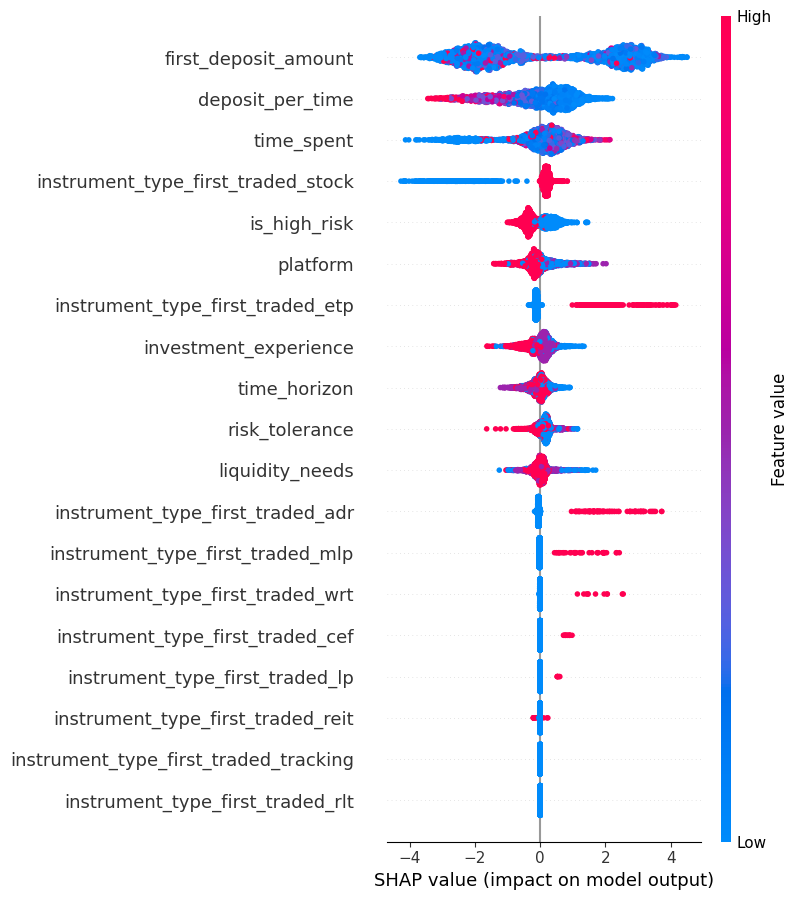

In [11]:
# Explain the model predictions using SHAP
explainer = shap.TreeExplainer(best_model)
shap_values = explainer.shap_values(X_test)

# Plot the SHAP summary
shap.summary_plot(shap_values, X_test, feature_names=X.columns)


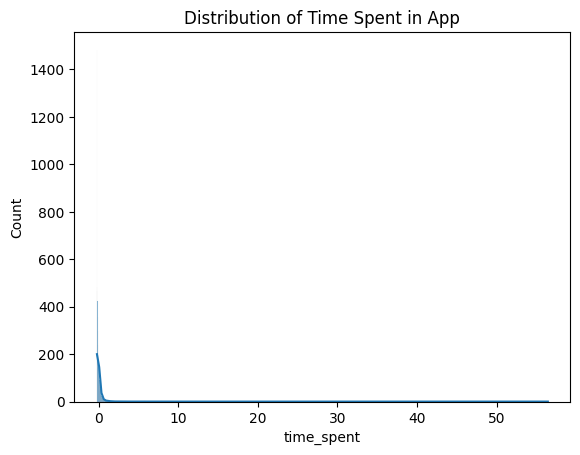

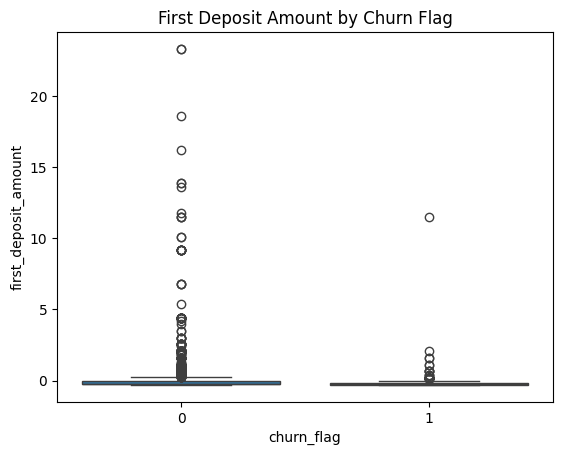

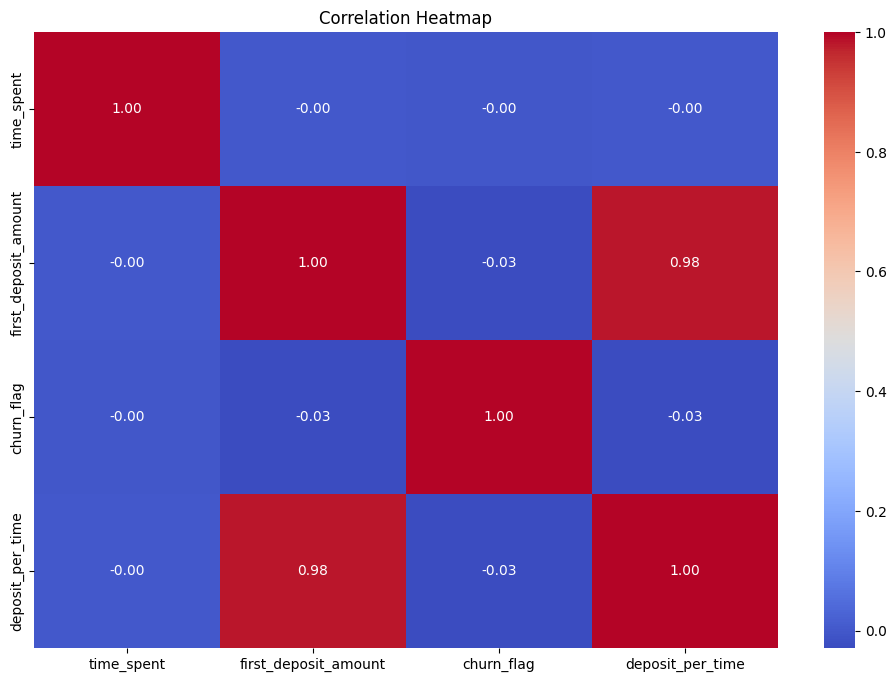

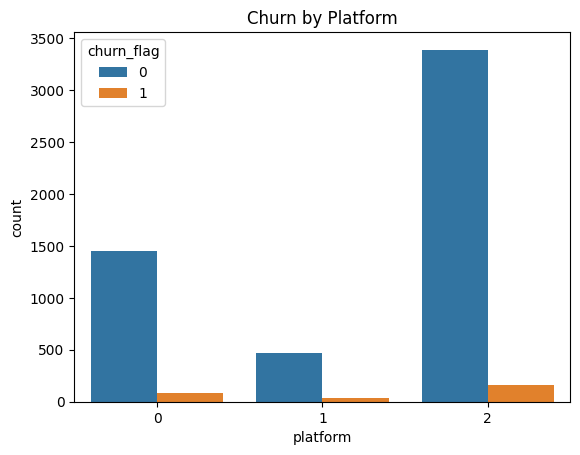

In [13]:
# Distribution of time spent in app
sns.histplot(df['time_spent'], kde=True)
plt.title('Distribution of Time Spent in App')
plt.show()

# Boxplot of first deposit amount by churn flag
sns.boxplot(x='churn_flag', y='first_deposit_amount', data=df)
plt.title('First Deposit Amount by Churn Flag')
plt.show()

# Select only the numerical columns from the DataFrame
numerical_df = df.select_dtypes(include=['float64', 'int64'])

# Create the heatmap using the correlation matrix of the numerical columns
plt.figure(figsize=(12, 8))
sns.heatmap(numerical_df.corr(), annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

# Countplot for churn by platform for categorical features
sns.countplot(x='platform', hue='churn_flag', data=df)
plt.title('Churn by Platform')
plt.show()
